<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/PISTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>This notebook breaksdown the PISTA package</b></h1></center>

# **Install**

In [1]:
!pip install photutils --quiet
!pip install reproject --quiet
!pip install GalSim --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 20.5 MB/s eta 0:00:00


# **GitHub**

In [2]:
!git clone https://github.com/Jack3690/INSIST --quiet

In [3]:
cd /content/INSIST/data

/content/INSIST/data


# **Imports**

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from tqdm.contrib import tzip

import cv2
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle, Distance, ICRS
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.io import fits
from astropy.io.fits import CompImageHDU
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_sigma_to_fwhm, sigma_clipped_stats
from astropy.table import Table, vstack, join_skycoord, join, QTable
from astropy.modeling.models import custom_model

from matplotlib import cm
from matplotlib.ticker import LogLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib import colors as col
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import angular_separation

from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
from photutils.isophote import Ellipse

import photutils as phot
from photutils.segmentation import SourceCatalog, deblend_sources, detect_sources

from photutils.detection import IRAFStarFinder, DAOStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup, FittableImageModel

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, LocalBackground
from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder, GriddedPSFModel
from photutils.psf import SourceGrouper, extract_stars, IterativePSFPhotometry, DAOPhotPSFPhotometry

from astropy.modeling.fitting import LevMarLSQFitter

from reproject import reproject_interp, reproject_exact
from reproject.mosaicking import reproject_and_coadd
from reproject.mosaicking import find_optimal_celestial_wcs

import galsim

from scipy.stats import norm
from scipy.constants import c
from scipy.signal import fftconvolve
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
import copy

import os
from time import perf_counter
import json
import requests

sb.set_style('white')
matplotlib.rcParams['font.size']= 20
matplotlib.rcParams['figure.figsize']=(10,10)

In [5]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable

In [6]:
data_path = '/content/INSIST/src/pista/data'

# **Utils**

In [7]:
def bandpass(wav, flux, inputs, plot = True, fig = None, ax = None):
  """
  Function to convolve response functions

  Parameters
  ----------
  wav : numpy.ndarray
        wavelenth in angstrom
  flux: numpy.ndarray
        flux normalized to [0,1]
  plot: bool,
        If true shows plots with input and convolved response functions

  fig : matplotlib.pyplot.figure
        User defined figure
  ax  : matplotlib.pyplot.axes
        User defined axes

  Returns
  -------

  fig, ax, data, params

  data : tuple,
        (wavelenth array, flux_array, convolved flux array)

  params: tuple,
          (effective wavelength, integrated flux, Effective Width)

  """
  lambda_   =  wav
  flux_AB   = flux

  if plot:
    if fig is None or ax is None:
        fig, ax = plt.subplots(1,1, figsize = (12,8))
    ax.plot(lambda_ ,flux_AB/flux_AB.max(),label = r'$F(\lambda)$', alpha = 0.7 )

  R_eff = 1

  for i in inputs:
    file_name = i.split(',')[0]
    n         = float(i.split(',')[1])
    f_max     = float(i.split(',')[2])

    filt_dat  = np.loadtxt(file_name)
    wav  = filt_dat[:,0]
    flux = filt_dat[:,1]

    if np.amax(flux)>1:
      flux/=f_max

    indices  = np.where( (wav>lambda_ [0]) & (wav<lambda_[-1]))
    wav_new  = wav[indices]
    flux_new = flux[indices]

    wav_new  = np.concatenate([[lambda_ [0]], [wav_new[0]- 1], wav_new,
                               [wav_new[-1]+ 1], [lambda_[-1]]])

    flux_new = np.concatenate([[0], [0], flux_new, [0], [0]])

    flux_out = np.interp(lambda_,wav_new,flux_new)

    R_eff      *= flux_out**n

    if plot:
      ax.plot(lambda_ ,flux_out/flux_out.max(),
              label=f"{file_name.split('/')[-1][:-4]}x{n}", alpha = 0.7)

  # Wavelength units
  conv_flux    = R_eff*flux_AB
  int_flux     = np.trapz(lambda_*conv_flux,lambda_)/np.trapz(lambda_*R_eff,
                                                              lambda_)
  W_eff        = np.trapz(R_eff,lambda_)/R_eff.max()
  lambda_phot  = np.trapz(lambda_**2*conv_flux,
                          lambda_)/np.trapz(lambda_*conv_flux,lambda_)

  c1 = lambda_ >= lambda_phot-W_eff/2
  c2 = lambda_ <= lambda_phot+W_eff/2

  R_sq         = np.where((c1 & c2),1,0)
  flux_ratio   = np.trapz(R_eff,lambda_)/np.trapz(R_sq,lambda_)

  if plot:
      ax.plot(lambda_ ,R_sq,
              label="Square Filter", alpha = 0.7)

  # Frequency units
  R_eff_Jy      = R_eff*lambda_**2*3.34e4
  flux_AB       = flux_AB*lambda_**2*3.34e4
  nu            = 3e18/lambda_

  conv_flux_Jy  = R_eff_Jy*flux_AB
  int_flux_Jy   = np.trapz(nu*conv_flux_Jy,nu)/np.trapz(nu*R_eff_Jy, nu)

  # Comparing to a square filter with same width

  data       =  lambda_, conv_flux, R_eff
  params     =  lambda_phot, int_flux, int_flux_Jy, W_eff, flux_ratio

  if plot:
    ax.plot(lambda_,conv_flux/conv_flux.max(),label = 'Convloved Flux',
            linewidth = 5)
    y = np.linspace(0,1)
    x = y*0 + lambda_phot
    label = r'$\lambda_{phot} = $' + f'{round(lambda_phot,3)}' + r' $\AA$'
    ax.plot(x,y,'--', color = 'black',label = label )

    ax.set_xlabel(r'$\AA$')
    ax.set_ylabel(r'Normalized Flux')
    fig.suptitle('Bandpass', fontsize = 20, y = 0.95)
    ax.legend()

  return fig, ax, data, params

In [8]:
def generate_psf(npix, params, function = 'Gaussian'):

    """
    Function for generating user defined PSF

    npix : int,
           number of pixels along one axis for pixel array

    sigma: float,
           standard deviation of the PSF in pixels

    function: str,
               type of PSF function

    Returns
    -------

    numpy.ndarray

    """
    x       = np.linspace(0, npix - 1, npix)
    y       = x
    yy,xx   = np.meshgrid(x,y)
    if function == 'Gaussian':
        sigma_x = params['sigma_x']
        sigma_y = params['sigma_y']
        psf = models.Gaussian2D(1, npix//2, npix//2,
                                sigma_x, sigma_y)(xx,yy)
        psf /= psf.sum()

    elif function == 'Moffat':
      gamma = params['gamma']
      alpha = params['alpha']
      psf = models.Moffat2D(1, npix//2, npix//2,
                          gamma, alpha)(xx,yy)
      psf /= psf.sum()

    np.save('user_defined_psf.npy',psf)
    return psf

In [9]:
def redshift_corr(df):
  """
  Function for redshift correction of input data

   Parameters
    ----------

    df: astropy.table.Table or pandas.DataFrame
        table with columns 'wav', 'flux', 'z1' and 'z2'

        wav: numpy.ndarray
            wavelength in Angstrom
        flux: numpy.ndarray
              flux in ergs/s/cm2/A

        z1: float,
            Original redshift to star
        z2: float,
            New redshift to star

    Returns
    -------

    astropy.table.Table or pandas.DataFrame
  """
  if 'z1' in df.keys() and 'z2' in df.keys():
    red_corr = df['z2'].value.reshape(-1,1)-df['z1'].value.reshape(-1,1)
    df['wav'] = df['wav'].value*(1 + red_corr)
    d1 = cosmo.luminosity_distance(df['z1']).value
    d2 = cosmo.luminosity_distance(df['z2']).value
    flux_corr = (d1/d2)**2

  elif 'd1' in df.keys() and 'd2' in df.keys():
    flux_corr = (df['d1'].value/df['d2'].value)**2

  df['flux'] = df['flux'].value*flux_corr.reshape(-1,1)

  return df

In [10]:
def spectra_to_mags_df(df,inputs):
  """
    Function to convert spectra to magnitude using telescope response functions
    Using Astropy Table

    Parameters
    ----------

    df: astropy.table.Table
        table with columns 'wav', 'flux', 'd1' and 'd2' or 'z1' or 'z2'

        wav: numpy.ndarray
            wavelength in Angstrom
        flux: numpy.ndarray
              flux in ergs/s/cm2/A

        d1: float,
            Original distance to star.
        d2: float
            New distance to star

        z1: float,
            Original redshift to star
        z2: float,
            New redshift to star

    inputs: list,
            list of path to response functions

    Returns
    -------

    astropy.table.Table

  """
  mags = []
  c1 = ('z1' in df.keys() and 'z2' in df.keys())
  c2 = ('d1' in df.keys() and 'd2' in df.keys())

  if c1 or c2 :
    df = redshift_corr(df)
  else:
    KeyError("z1 and z2 or d1 and d2")

  fluxes = df['flux'].value
  wavs = df['wav'].value

  for wav, flux in zip(wavs, fluxes):
    out = bandpass(wav, flux,inputs = inputs,
                                          plot = False)
    params = out[3]
    int_flux_Jy = params[2]
    ABmag = -2.5*np.log10(int_flux_Jy/3631)

    if ABmag == np.nan:
      ABmag  = 100
    mags.append(ABmag)

  df['mag'] = mags

  return df

In [11]:
def spectra_to_mags(wav, flux, inputs, z1=None, z2=None, d1=None,d2=None):
  """
    Function to convert spectra to magnitude using telescope response functions
    Using Astropy Table

    Parameters
    ----------

    wav: list of numpy.ndarray
        wavelength in Angstrom
    flux: list of numpy.ndarray
          flux in ergs/s/cm2/A

    inputs: list,
        list of path to response functions

    d1: float,
        Original distance to star.
    d2: float
        New distance to star

    z1: float,
        Original redshift to star
    z2: float,
        New redshift to star

    Returns
    -------
    ABmag: numpy.ndarray
           magnitude of stars from spectra
  """
  c1 = z1 is not None and z2 is not None
  c2 = d1 is not None and d2 is not None

  if c1:

    wav = wav*(1 + z1 - z2)
    d1 = cosmo.luminosity_distance(z1).value
    d2 = cosmo.luminosity_distance(z2).value
    flux_corr = (d1/d2)**2

  elif c2:
    flux_corr = (d1/d2)**2

  flux *= flux_corr
  out           = bandpass(wav, flux,inputs = inputs,
                                        plot = False)
  params         = out[3]
  int_flux_Jy    = params[2]
  ABmag          = -2.5*np.log10(int_flux_Jy/3631)

  if ABmag == np.nan:
    ABmag  = 100

  return ABmag

In [12]:
def calc_mos_size(L,B,PA,l):
  """
    Function to calculate minimum size of a Multi-object Spectrometer (MOS)
    detector based on it's orientation and shape

    Parameters
    ----------

    L: float,
        Length of MOS Field of View (FoV).

    B: float,
        Breadth of MOS FoV.

    PA: float,
          Orientation of MOS FoV with respect to sky plane. (degrees)

    l: int,
          Number of pixels in dispersion direction.

    Returns
    -------

    x_size, y_size: tuple
                      (int,int)
  """
  PA *= np.pi/180
  x_size = l + B*np.sin(PA) + L*np.cos(PA)
  y_size = B*np.cos(PA) + L*np.sin(PA)
  x_size = int(np.round(x_size,0))
  y_size = int(np.round(y_size,0))

  return x_size, y_size

In [13]:
def select_mos(df, cen_x, cen_y, radius = 10, min_sep = 10,ny =1000):
  """
    Function to select sources from a given database such that overlap of
    spectra is minimum
    Parameters
    ----------

     df1: astropy.table.Table,
        table with columns 'ra' and 'dec'

        ra: float,
            Right Ascension in degrees

        dec: float,
            Declnation in degrees

      cen_x, float,
              Reference x position in pixel coordinates

      cen_y: float,
              Reference x position in pixel coordinates

      radius: float,
              Radius of circle to count stars within.

      min_sep: float,
                minimum separation between stars in the spatial axis,


      ny: int,
            length of spatial axis in pixels


    Returns
    -------

    mos_df: astropy.table.Table,
              table containing list of selected sources
    res_df: astropy.table.Table,
              table containing list of remaining sources


  """
  catalog = df[['x', 'y']].values
  result = count_sources_within_radius(catalog, radius)
  df['n_density'] = result

  top = np.flip(np.arange(cen_y, 0, -min_sep))
  bottom = np.arange(cen_y + min_sep, ny, min_sep)

  y_pos = np.concatenate([top, bottom])
  mos_df = []
  df['x_sep'] = abs(df['x']- cen_x)
  for i in y_pos:
    p = df[(df['y']>i-2) & (df['y']<i+2)]
    p = p[p['n_density']==0]

    if len(p)>0:
      p = p[p['x_sep']==p['x_sep'].min()]
      mos_df.append(p.values[0])

  mos_df = pd.DataFrame(mos_df, columns = df.keys())

  res_df = mos_df[0:0]
  for id in df['objid']:
    if id not in mos_df['objid'].values:
      t = df[df['objid']==id]
      res_df = pd.concat([res_df,t])

  return mos_df, res_df, cen_x, cen_y

In [14]:
def count_sources_within_radius(catalog, radius):
  """
    Function for counting the number of source around each stat within a given
    radius using KDTree

    Parameters
    ----------

    catalog: (np.ndarray, np.ndarray),
              source coordinates

    radius: float,
              radius of circle to count sources within

    Returns
    -------

    counts: list,
            number density of sources around each star

  """
  tree = cKDTree(catalog)
  counts = []

  for star in catalog:
      indices = tree.query_ball_point(star, radius)
      count = len(indices) - 1  # Exclude the star itself from the count
      counts.append(count)

  return counts

In [15]:
def distance_transform(ras,decs, cen_ra,cen_dec, d1,d2):

  """
    Function for distance transformation of sources scattered around a point.

    Parameters
    ----------

    ras: np.ndarray,
          Right Ascension of sources.

    decs: np.ndarray,
          Declination of sources.

    cen_ra: float,
            Reference Right Ascension

    cen_dec: float,
              Reference Declination

    d1: astropy.units.ly, astropy.units.pc, astropy.units.Mpc

    d2: astropy.units.ly, astropy.units.pc, astropy.units.Mpc

    Returns
    -------

   new_star_coords.ra.value, new_star_coords.ra.value: np.ndarray, np.ndarray

  """

  # Define the coordinates of the galaxy in the original catalog
  galaxy_ra = cen_ra*u.deg
  galaxy_dec = cen_dec*u.deg

  # Define the coordinates of the stars in the original catalog
  star_ra = ras*u.deg
  star_dec = decs*u.deg

  # Create a SkyCoord object for the galaxy in the original catalog
  galaxy_coord = SkyCoord(ra=galaxy_ra, dec=galaxy_dec, distance=Distance(d1), frame=ICRS())

  # Create a SkyCoord object for the stars in the original catalog
  star_coords = SkyCoord(ra=star_ra, dec=star_dec, frame=ICRS())

  # Calculate the factor by which to scale the coordinates
  scale_factor = d1/d2

  # Calculate the separation between the stars and the galaxy
  separation = star_coords.separation(galaxy_coord)

  # Calculate the new position angle using the original coordinates
  position_angle = star_coords.position_angle(galaxy_coord)

  # Scale the separation by the scale factor
  scaled_separation = np.arctan(np.tan(separation)*scale_factor)

  # Calculate the new star coordinates using the scaled separation and position angle
  new_star_coords = galaxy_coord.directional_offset_by(position_angle, scaled_separation)

  return new_star_coords.ra.value, new_star_coords.dec.value

# **Photometry**

In [16]:
class Analyzer(object):
    def __init__(self):
        """
        A class to visualize and analyze the simulated image

        Parameters
        ----------


        Returns
        -------
        None.

        """
    def __call__(self, df=None, wcs=None, data=None,
                 photometry=None, detect_sources=False, fwhm=3, sigma=13,
                 ZP=None):
        """
        Performs sim simulation and sim Photometry

        Imager.call()

        do_photometry : Bool, Default : True
                        Do Aperture Photometry
        """
        self.photometry_type = photometry
        if photometry == 'Aper':
            self.aper_photometry(data, wcs, df, fwhm, sigma, detect_sources,
                                 ZP)
        elif photometry == 'PSF':
            self.psf_photometry(data, wcs, df, fwhm, sigma, ZP)

    def aper_photometry(self, data, wcs, df, fwhm, sigma, detect, ZP):
      """
      Function to perform Aperture photometry

      Parameters
      ----------

      data: np.ndarray,
            image to perform photometry on

      wcs: astropy.wcs.WCS
            WCS object of the image

      df: pandas.DataFrame,
          Source catalog of source in the image from simulation for
          reference

      fwhm : float, pixels
                  During aperture photometry,
                  fwhm corresponds to FWHM circular aperture for
                  aperture photometry
                  During PSF photometry,
                  fwhm corresponds FWHM kernel to use for PSF photometry
      sigma: float,
              The numbers of standard deviations above which source has to be
              detected
      detect: bool,
              If true, DARStarFinder is used to detect sources for aperture
              photometry

              if false, input catalog is used for getting positions
              of sources for aperture photometry
      ZP    : float,
              zero point of the telescope.

      Returns
      -------

      phot_table: astropy.table.Table
                  table containing photometry of the souces

                  Columns
                    'x-centeroid'
                    'y-centeroid'
                    'sky'
                    'flux'
                    'mag_in'
                    'mag_out'
                    'mag_err'
                    'SNR'

      """

      # if detect flag is set to True, detect sources in the image
      if detect:

          bkgrms = MADStdBackgroundRMS()
          mmm_bkg = MMMBackground()

          sigma_clip = SigmaClip(sigma=3.0)

          if self.Cal0:
            print("Performing photometry on Level 1 data")
            mask = np.where(np.isnan(data) | np.isinf(data) | \
                                                (data<=0),1, 0)
          else:
            print("Performing photometry on Level 0 data")
            mask = np.where(data==0,1,0)

          bkg = Background2D(data, (100, 100),
                                filter_size=(3, 3),
                                sigma_clip=sigma_clip,
                                bkg_estimator=mmm_bkg,
                                coverage_mask=mask,
                                fill_value = 0.0)

          data_bkgsub = data.copy() - bkg.background

          _, _, std = sigma_clipped_stats(data_bkgsub)

          daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm)

          sources = daofind(data_bkgsub, mask=mask)
          # Get the source positions
          positions = np.transpose((sources['xcentroid'],
                                    sources['ycentroid']))

      else:

          # create SkyCoord object from ra and dec values in the dataframe
          coords = np.array([df['ra'],df['dec']])
          # convert the sky coordinates to pixel coordinates
          pix = wcs.world_to_pixel_values(coords.T)
          positions = np.array(pix)

      # create circular aperture object
      self.aps = CircularAperture(positions, r=2*fwhm)
      # count number of pixels within the aperture
      ap_pix = self.aps.area
      # create circular annulus object

      self.bags = CircularAnnulus(positions, r_in=3*fwhm,
                                        r_out=5*fwhm)
      # count number of pixels within the annulus
      sky_median = ApertureStats(data, self.bags).median

      # perform aperture photometry on the data
      phot_table = aperture_photometry(data, self.aps)

      # calculate sky flux. electrons
      phot_table['sky_flux'] = sky_median*ap_pix*self.gain*u.electron

      # calculate source flux
      phot_table['flux'] = (self.gain*phot_table['aperture_sum'].value - \
                           phot_table['sky_flux'].value)*u.electron

      # calculate error on the source flux
      NE_2 =  phot_table['flux'].value + phot_table['sky_flux'].value + \
              (self.DC_array.mean() + self.det_params['RN']**2 + \
                            (self.gain/2)**2)*ap_pix

      phot_table['flux_err'] = np.sqrt(NE_2)*u.electron

      # calculate signal to noise ratio
      phot_table['SNR'] = phot_table['flux']/phot_table['flux_err']

      if not detect:

          phot_table['ra'] = df['ra'].values
          phot_table['dec'] = df['dec'].values
          phot_table['mag_in'] = df['mag'].values

      else:
          coords = np.array(wcs.pixel_to_world_values(positions))

          phot_table['SkyCoord'] = SkyCoord(ra = coords[:, 0],
                                            dec = coords[:, 1],
                                            unit = 'deg')
          tab2 = Table.from_pandas(df)

          tab2['SkyCoord'] = SkyCoord(ra = df['ra'],
                                      dec = df['dec'],
                                      unit = 'deg')

          min_dist = join_skycoord(2*self.pixel_scale*u.arcsec)

          phot_table = join(phot_table, tab2['mag', 'x', 'y', 'SkyCoord'],
                           join_funcs={'SkyCoord': min_dist})

          phot_table.rename_column('mag', 'mag_in')

      phot_table['mag_out'] = -2.5*np.log10(phot_table['flux'].value) + ZP
      phot_table['mag_err'] = 1.082/phot_table['SNR'].value

      self.phot_table = phot_table

    def psf_photometry(self, data, wcs, df, fwhm, sigma, ZP):
        """
        Function to perform PSF photometry

        Parameters
        ----------

        data: np.ndarray,
              image to perform photometry on

        wcs: astropy.wcs.WCS
              WCS object of the image

        df: pandas.DataFrame,
            Source catalog of source in the image from simulation for
            reference

        fwhm : float, pixels
                    During aperture photometry,
                    fwhm corresponds to FWHM circular aperture for
                    aperture photometry
                    During PSF photometry,
                    fwhm corresponds FWHM kernel to use for PSF photometry
        sigma: float,
                The numbers of standard deviations above which source has to be
                detected
        detect: bool,
                If true, DARStarFinder is used to detect sources for aperture
                photometry

                if false, input catalog is used for getting positions
                of sources for aperture photometry
        ZP    : float,
                zero point of the telescope.

        Returns
        -------

        phot_table: astropy.table.Table
                    table containing photometry of the souces

                    Columns
                      'x-centeroid'
                      'y-centeroid'
                      'sky'
                      'flux'
                      'mag_in'
                      'mag_out'
                      'mag_err'
                      'SNR'
        """
        mean, median, std = sigma_clipped_stats(data, sigma=3)

        psf_model = FittableImageModel(self.psf)
        self.psf_model = psf_model

        fitter = LevMarLSQFitter()
        sigma_clip = SigmaClip(sigma_lower=2.25, sigma_upper=2.00)
        bkgstat = MMMBackground(sigma_clip=sigma_clip)
        localbkg_estimator = LocalBackground(15, 35, bkgstat)

        fwhm_psf = fwhm

        bkgrms = MADStdBackgroundRMS()
        mmm_bkg = MMMBackground()

        #sigma_clip = SigmaClip(sigma=sigma)
        sigma_clip = SigmaClip(sigma=sigma)
        if self.Cal0:
            print("Performing photometry on Level 1 data")
            mask = np.where(np.isnan(data) | np.isinf(data) | \
                                                (data<=0),1, 0)
        else:
            print("Performing photometry on Level 0 data")
            mask = np.where(data==0,1,0)

        bkg = Background2D(data, (100, 100),
                              filter_size=(3, 3),
                              sigma_clip=sigma_clip,
                              bkg_estimator=mmm_bkg,
                              coverage_mask=mask,
                              fill_value = 0.0)

        data_bkgsub = data.copy() - bkg.background

        daofind = DAOStarFinder(threshold=5*std, fwhm=fwhm_psf)
        grouper = SourceGrouper(2*fwhm_psf)

        photometry = IterativePSFPhotometry(finder=daofind, grouper=grouper,
                                  localbkg_estimator=localbkg_estimator,
                                  psf_model=psf_model,fitter=fitter,
                                  maxiters=1, fit_shape=(11,11),
                                  aperture_radius=3*fwhm,
                                  sub_shape=self.psf.shape,
                                  progress_bar=True)

        phot_table = photometry(data_bkgsub)

        self.resid = photometry.make_residual_image(data_bkgsub,
                                                    self.psf.shape)

        positions = np.array([phot_table['x_fit'], phot_table['y_fit']]).T
        coords = np.array(wcs.pixel_to_world_values(positions))

        ap_pix = 11*11

        phot_table['flux_fit_err'] = self.gain*phot_table['flux_err']

        phot_table['flux_fit'] = self.gain*phot_table['flux_fit']*u.electron

        NE_2 = (phot_table['flux_fit'].value + \
                phot_table['flux_fit_err'].value) + \
                (self.DC_array.mean() + self.det_params['RN']**2 + \
                (self.gain/2)**2)*ap_pix

        phot_table['flux_err'] = np.sqrt(NE_2)*u.electron

        phot_table['SNR'] = phot_table['flux_fit']/ phot_table['flux_err']

        phot_table['mag_out'] = -2.5*np.log10(phot_table['flux_fit'].value)
        phot_table['mag_out'] += ZP
        phot_table['mag_err'] = 1.082/phot_table['SNR'].value

        phot_table['SkyCoord'] = SkyCoord(ra = coords[:, 0],
                                            dec = coords[:, 1],
                                            unit = 'deg')
        tab2 = Table.from_pandas(df)

        tab2['SkyCoord'] = SkyCoord(ra = df['ra'],
                                    dec = df['dec'],
                                      unit = 'deg')
        min_dist = join_skycoord(2*self.pixel_scale*u.arcsec)
        phot_table = join(phot_table, tab2['mag', 'x', 'y', 'SkyCoord'],
                          join_funcs={'SkyCoord': min_dist})

        phot_table.rename_column('mag', 'mag_in')

        positions = np.array([phot_table['x_fit'].value,
                              phot_table['y_fit'].value]).T
        self.aps = CircularAperture(positions, r=2*fwhm)

        self.phot_table = phot_table

    def show_field(self, figsize=(12, 10), marker='.', cmap='jet'):
        """
        Function for creating a scatter plot of sources within the FoV

        Parameters
        ----------
        figsize : tuple,
                Figure size

        Returns
        -------
        fig, ax
        """
        scale = self.n_x/self.n_y
        figsize = figsize[0]*scale, figsize[1]

        # Cropping Dataframe based on FoV
        left = (self.n_x_sim - self.n_x)//2
        right = left + self.n_x

        df = self.sim_df

        x_min_cut = (df['x'] > left)
        x_max_cut = (df['x'] < right)

        df = df[x_min_cut & x_max_cut]

        bottom = (self.n_y_sim - self.n_y)//2
        top = bottom + self.n_y

        y_min_cut = (df['y'] > bottom)
        y_max_cut = (df['y'] < top)

        fov_x = (self.n_x*self.pixel_scale)/3600
        fov_y = (self.n_y*self.pixel_scale)/3600

        fov_x = np.round(fov_x, 4)
        fov_y = np.round(fov_y, 4)

        df = df[y_min_cut & y_max_cut]

        fig, ax = plt.subplots(1, 1, figsize=figsize)

        if hasattr(self, 'spec_bins'):
          x = df['x']
          y = df['y']
          c = None
          cmap = None
          color = None

          if 'mag' in df.keys():
            c = df['mag']
            cmap = 'jet'
            color = None

          img = ax.scatter(x, y, c=c, color = color, cmap=cmap, marker=marker)
          cb = plt.colorbar(img, fraction = 1/scale, pad =0.01)
          cb.set_label('mag (ABmag)')
          ax.set_title(f"""Requested Center : {self.name} | {len(df)} sources
          Fov(RA) : {fov_x} (deg) | Fov(Dec) : {fov_y} (deg)""")
          ax.set_xlabel('x (pix)')
          ax.set_ylabel('y (pix)')

          if hasattr(self, 'L'):
            B = self.B
            L = self.L
            l = len(self.spec_bins)
            PA = self.PA

            delta = np.arctan(B/L)
            d = np.sqrt(L**2 + B**2)/2
            om = PA - delta

            x_corr = self.n_x_sim//2 - d*np.cos(om) - l/2
            y_corr = self.n_y_sim//2 - d*np.sin(om) - B*np.cos(PA)

            start = B*np.sin(PA) + l/2 + x_corr
            end = start + L*np.cos(PA)
            x = np.linspace(start,end,100)
            y = np.tan(PA)*(x - B*np.sin(PA) - l/2 - x_corr) + y_corr

            ax.plot(x,y,color = 'red')

            start = l/2 + x_corr
            end = start + L*np.cos(PA)
            x = np.linspace(start, end, 100)
            y = np.tan(PA)*(x - l/2  - x_corr) + B*np.cos(PA) + y_corr

            ax.plot(x,y,color = 'red')

            start = y_corr
            end = start + B*np.cos(PA)
            y = np.linspace(start, end, 100)
            x = -np.tan(PA)*(y - B*np.cos(PA) - y_corr) + l/2 + x_corr

            ax.plot(x,y,color = 'red')

            start = y_corr +  L*np.sin(PA)
            end = start + B*np.cos(PA)
            y = np.linspace(start, end, 100)
            x = -np.tan(PA)*(y - B*np.cos(PA) - L*np.sin(PA) - y_corr) + L*np.cos(PA) + l/2 + x_corr

            ax.plot(x,y,color = 'red')
            ax.set_xlim(0,self.n_x_sim)
            ax.set_ylim(0,self.n_y_sim)

        else:

          x = df['ra']
          y = df['dec']
          c = df['mag']

          img = ax.scatter(x, y, c=c, marker=marker, cmap=cmap)
          cb = plt.colorbar(img)
          cb.set_label('mag (ABmag)')

          ax.set_title(f"""Requested Center : {self.name} | {len(df)} sources
          Fov(RA) : {fov_x} (deg) | Fov(Dec) : {fov_y} (deg)""")
          ax.invert_xaxis()
          ax.set_xlabel('RA (Degrees)')
          ax.set_ylabel('Dec (Degrees)')
          ax.invert_xaxis()
          ax.set_xlim(self.ra+fov_x/2, self.ra-fov_x/2)
          ax.set_ylim(self.dec-fov_y/2,self.dec+fov_y/2)

        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

        ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
                      bottom = True, left = True)

        return fig, ax

    def show_image(self, source='Digital', fig=None, ax=None, cmap='jet',
                   figsize=(15, 10), download=False, show_wcs=True,
                   overlay_apertures=False):
        """
        Function for plotting the simulated field image

        Source: str,
                Choose from
                            'Digital' : Final digial image
                            'Charge'  : electrons, Light(Source + sky) +
                                         Dark Current + Noises
                            'Source'  : Source + Sky + Noises
                            'Sky'     : Sky + shot_noise
                            'DC'      : Dark Current + DNFP
                            'QE'      : Quantum efficiency fluctuation across
                                        detector
                            'Bias'    : Charge offset
                            'PRNU'    : Photon Response Non-Uniformity
                            'DNFP'    : Dark Noise Fixed Pattern
                            'QN'      : Quantization Noise
                            'Resid'   : Residual Image If PSF Photometry
                                         was performed


        fig : matplotlib.pyplot.figure
            User defined figure
        ax  : matplotlib.pyplot.axes
            User defined axes
        cmap : str,
            matplotlib.pyplot colormap
        figsize : tuple
        download : bool
        show_wcs : bool
                If true adds WCS projection to the image
        Returns
        -------
        Image

        fig, ax
        """
        if hasattr(self,'digital'):
            if fig is None or ax is None:
                fig = plt.figure(figsize=figsize)
                if show_wcs:
                    ax = fig.add_subplot(projection=self.wcs)
                else:
                    ax = fig.add_subplot()

            norm = None
            if source == 'Digital':
                data = self.digital
                norm = col.LogNorm()
            elif source == 'Charge':
                data = self.charge
                norm = col.LogNorm()
            elif source == 'Source':
                data = self.light_array
                norm = col.LogNorm()
            elif source == 'Sky':
                data = self.sky_photons
            elif source == 'DC':
                data = self.DC_array
            elif source == 'Bias':
                data = self.bias_array
            elif source == 'PRNU':
                data = self.PRNU_array
            elif source == 'DNFP':
                norm = col.LogNorm()
                data = self.DNFP_array
            elif source == 'QN':
                data = self.QN_array
            elif source == 'Resid':
              if self.photometry_type == "PSF":
                data = self.resid
              else:
                print("Run PSF Photometry!")
                return None, None
            else:
                print("Invalid Input")
                return None, None

            if data.min() < 0:
                print('Negative values in image. Increase Bias')
                data += data.min()

            img = ax.imshow(data, cmap=cmap, norm=norm)
            ax.grid(False)
            cb = plt.colorbar(img, ax=ax)
            cb.set_label('DN')
            ax.set_title(f'{source} \nRequested center : {self.name}')
            ax.grid(False)

            if overlay_apertures:
              if self.photometry_type == "Aper":
                for aperture in self.aps:
                    if aperture is not None:
                        aperture.plot(ax=ax, color='red', lw=1.5)
                for aperture in self.bags:
                    if aperture is not None:
                        aperture.plot(ax=ax, color='yellow', lw=1.5)

              elif self.photometry_type == "PSF":
                for aperture in self.aps:
                    if aperture is not None:
                        aperture.plot(ax=ax, color='red', lw=1.5)


            if hasattr(self, 'L'):
              B = self.B
              L = self.L
              l = len(self.spec_bins)
              PA = self.PA

              delta = np.arctan(B/L)
              d = np.sqrt(L**2 + B**2)/2
              om = PA - delta

              x_corr = self.n_x//2 - d*np.cos(om) - l/2
              y_corr = self.n_y//2 - d*np.sin(om) - B*np.cos(PA)

              start = B*np.sin(PA) + l/2 + x_corr
              end = start + L*np.cos(PA)
              x = np.linspace(start,end,100)
              y = np.tan(PA)*(x - B*np.sin(PA) - l/2 - x_corr) + y_corr

              ax.plot(x,y,color = 'red')

              start = l/2 + x_corr
              end = start + L*np.cos(PA)
              x = np.linspace(start, end, 100)
              y = np.tan(PA)*(x - l/2  - x_corr) + B*np.cos(PA) + y_corr

              ax.plot(x,y,color = 'red')

              start = y_corr
              end = start + B*np.cos(PA)
              y = np.linspace(start, end, 100)
              x = -np.tan(PA)*(y - B*np.cos(PA) - y_corr) + l/2 + x_corr

              ax.plot(x,y,color = 'red')

              start = y_corr +  L*np.sin(PA)
              end = start + B*np.cos(PA)
              y = np.linspace(start, end, 100)
              x = -np.tan(PA)*(y - B*np.cos(PA) - L*np.sin(PA) - y_corr) + L*np.cos(PA) + l/2 + x_corr

              ax.plot(x,y,color = 'red')

            if download:
                fig.savefig(f"{source}.png", format='png')
            return fig, ax

        else:
            print("Run Simulation")

    def show_hist(self, source='Digital', bins=None,
                  fig=None, ax=None, figsize=(15, 8)):
        """
        Function for plotting histogram of various stages of simulation

        Parameters
        ----------

        Source: str,
                Choose from
                        'Digital' : Final digial image
                        'Charge'  : electrons, Light(Source + sky)
                                    + Dark Current + Noises
                        'Source'  : Source + Sky + Noises
                        'Sky'     : Sky + shot_noise
                        'DC'      : Dark Current + DNFP
                        'QE'      : Quantum efficiency fluctuation across
                                    detector
                        'Bias'    : Charge offset
                        'PRNU'    : Photon Response Non-Uniformity
                        'DNFP'    : Dark Noise Fixed Pattern
                        'QN'      : Quantization Noise

        bins : numpy.array,
            bins for making histogram
        fig : matplotlib.pyplot.figure
            User defined figure
        ax  : matplotlib.pyplot.axes
            User defined axes
        figsize : tuple
        """

        if hasattr(self,'digital'):
            if fig is None or ax is None:
                fig, ax = plt.subplots(1, 1, figsize=figsize)

            if source == 'Digital':
                data = self.digital.ravel()
            elif source == 'Charge':
                data = self.charge.ravel()
            elif source == 'Source':
                data = self.light_array
            elif source == 'Sky':
                data = self.sky_photons.ravel()
            elif source == 'DC':
                data = self.DC_array.ravel()
            elif source == 'Bias':
                data = self.bias_array.ravel()
            elif source == 'PRNU':
                data = self.PRNU_array.ravel()
            elif source == 'DNFP':
                data = self.DNFP_array.ravel()
            elif source == 'QN':
                data = self.QN_array.ravel()

            if bins is None:
                bins = np.linspace(data.min(), data.max(), 20)
            ax.hist(data, bins=bins)
            ax.set_title(f'{source} histogram')
            ax.set_ylabel('Count')
            ax.set_yscale('log')
            return fig, ax
        else:
            print("Run Simulation")

    def getImage(self, source='Digital'):
        """
        Function of retrieving image array at different stages of simulation.

        Parameters
        ----------

        Source: str,
            Choose from
                        'Digital' : Final digial image
                        'Charge'  : electrons, Light(Source + sky)
                                    + Dark Current + Noises
                        'Source'  : Source + Sky + Noises
                        'Sky'     : Sky + shot_noise
                        'DC'      : Dark Current + DNFP
                        'QE'      : Quantum efficiency fluctuation across
                                    detector
                        'Bias'    : Charge offset
                        'PRNU'    : Photon Response Non-Uniformity
                        'DNFP'    : Dark Noise Fixed Pattern
                        'QN'      : Quantization Noise
        """

        if hasattr(self, 'digital'):
            if source == 'Digital':
                data = self.digital
            elif source == 'Charge':
                data = self.charge
            elif source == 'Sky':
                data = self.sky_photoelec
            elif source == 'DC':
                data = self.DC_array
            elif source == 'QE':
                data = self.qe_array
            elif source == 'Bias':
                data = (self.bias_array + self.DC_array)
            elif source == 'PRNU':
                data = self.PRNU_array
            elif source == 'DNFP':
                data = self.DNFP_array
            elif source == 'QN':
                data = self.QN_array
            else:
                data = 0
            return data
        else:
            print("Run Simulation")

    def writeto(self, name, source='Digital', user_source=None,
                with_dark_flat = False):

        """
        Function for downloading a fits file of simulated field image

        Parameters
        ----------
        name : str
            filename, Example : simulation.fits

        Source: str,
            Choose from
                        'Digital' : Final digial image
                        'Charge'  : electrons, Light(Source + sky)
                                    + Dark Current + Noises
                        'Source'  : Source + Sky + Noises
                        'Sky'     : Sky + shot_noise
                        'DC'      : Dark Current + DNFP
                        'Bias'    : Charge offset
                        'PRNU'    : Photon Response Non-Uniformity
                        'DNFP'    : Dark Noise Fixed Pattern
                        'QN'      : Quantization Noise

        user_source : numpy.ndarray
                    2D numpy array user wants to save as FITS
        with_dark_flat : bool
                          True : Output fits will provide dark and flat frames
        """
        if hasattr(self, 'digital'):
            if user_source is not None and isinstance(user_source) == np.ndarray:
                data = user_source
            elif source == 'Digital':
                data = self.digital
            elif source == 'Charge':
                data = self.charge
            elif source == 'Source':
                data = self.light_array
            elif source == 'Sky':
                data = self.sky_photoelec
            elif source == 'DC':
                data = self.DC_array
            elif source == 'Bias':
                data = self.bias_array
            elif source == 'PRNU':
                data = self.PRNU_array
            elif source == 'DNFP':
                data = self.DNFP_array
            elif source == 'QN':
                data = self.QN_array

            else:
                print(f"{source} is not a valid source")

            hdu = fits.PrimaryHDU(data, header=self.header)
            hdu.wcs = self.wcs
            hdus = [hdu]

            if with_dark_flat:
              bias = self.bias_frame
              header = self.header
              header['FRAME'] = 'Bias'

              hdu = fits.ImageHDU(bias, header=header)
              hdus.append(hdu)

              dark = self.dark_frame/self.exp_time
              header = self.header
              header['FRAME'] = 'Dark'

              hdu = fits.ImageHDU(dark, header=header)
              hdus.append(hdu)

              flat = self.flat_frame
              header['FRAME'] = 'Flat'

              hdu = fits.ImageHDU(flat, header=header)
              hdus.append(hdu)

            hdul = fits.HDUList(hdus)
            hdul.writeto(f'{name}', overwrite=True, checksum=True)
        else:
            print("Run Simulation")

    def writecomp(self, name):

      hdu = CompImageHDU(data=self.digital, header=self.header)
      hdus = [fits.PrimaryHDU(), hdu]
      hdul = fits.HDUList(hdus)
      hdul.writeto(name, overwrite = True, checksum = True)

In [17]:
class SpecAnalyzer(object):

    def __init__(self):
        """
        A class to visualize and analyze the simulated image

        Parameters
        ----------
        Imager.init()

        Returns
        -------
        None.

        """
    def extract(self, data, wcs, df, width=50, sep=5):

        """
        Extracts Spectra for Slitless Spectroscopy

        """
        coords = np.array([df['ra'], df['dec']])
        # convert the sky coordinates to pixel coordinates
        pix = wcs.world_to_pixel_values(coords.T)
        positions = np.array(pix)

        bin_mid = len(self.spec_bins)//2
        w = width//2

        fluxes = []
        for i, j in positions:

          i = np.round(i,1).astype(int)
          j = np.round(j,1).astype(int)

          start = i-bin_mid if i-bin_mid >= 0 else 0
          end = i+bin_mid if i+bin_mid <= self.n_x else self.n_x

          top = j - w  if j - w >= 0 else 0
          bottom = j + w if j + w <= self.n_y else self.n_y

          flux = data[top : bottom, start:end+1]

          if top >= w + sep  and bottom <= self.n_y - w - sep:
            top_ = top - w - sep
            bottom_ = top - sep
            sky = data[top_:bottom_, start:end+1]

            top_ = bottom + sep
            bottom_ = bottom + w + sep
            sky += data[top_:bottom_, start:end+1]

          elif top < w + sep:
              top_ = bottom + sep
              bottom_ = bottom + width + sep
              sky = data[top_ : bottom_, start:end+1]

          elif bottom > self.n_y - w - sep :
            top_ = top - sep - width
            bottom_ = top - sep
            sky = data[top_ : bottom_, start:end+1]

          fluxes.append(flux.sum(axis=0) - sky.sum(axis=0))

        self.spec_width = width
        self.phot_table = df[['ra', 'dec', 'z1', 'z2']]
        self.phot_table['flux'] = fluxes

    def cal_flux(self, flux, A=0, B=0.15):
      """
        Calibrate Flux by converting flux in counts to ergs/s/cm2/A
      """
      self.phot_table['flux'] = self.phot_table['flux']/self.UC

# **Simulator**

## **Imaging**

In [18]:
class Imager(Analyzer):
    """Imager class uses dataframe containing position and magntidue
    information to simulate image based on user defined telescope
    and detector characteristics
    """
    def __init__(self, df, coords=None, tel_params=None, n_x=1000,
                 n_y=1000, exp_time=100, plot=False, user_profiles=None):
        """
        Parameters
        ----------
        df     : pd.DataFrame,
                 Pandas dataframe with source catalog
        coords : (float, float),
                 (RA, Dec) in degrees
        tel_params : dict,
                     {'aperture'       : float,  cm
                      'pixel_scale'    : float,  arcsecs/pixels
                      'sim_file'       : fits,npy
                      'response_funcs' : list, [filename.dat, n] where n is
                                              number of times to multiply
                                              filter
                                              profile
                      'coeffs'         : float, filter coefficients if not
                                              response_funcs
                      }
        n_x      : int,
                   number of pixels along RA direction
        n_y      : int,
                   number of pixels along Dec direction
        exp_time : float
                   Exposure time in seconds
        """
        super().__init__()

        # Flags
        self.shot_noise = True
        self.QE = True
        self.sky = True
        self.PRNU = True
        self.DC = True
        self.DCNU = True
        self.DNFP = True
        self.QN = True
        self.Bias = True

        # Detector
        self.Cal0 = False

        # Flux
        self.Cal1 = False

        # TBD
        self.cosmic_rays = False

        # Telescope and Detector Parameters
        psf_file = f'{data_path}/PSF/INSIST/off_axis_hcipy.npy'
        sky_resp = f'{data_path}/Sky_mag.dat'

        self.tel_params = {'aperture': 100,  # cm
                           'pixel_scale': 0.1,
                           'psf_file': psf_file,
                           'response_funcs': [],
                           'sky_resp': sky_resp,
                           'coeffs': 1,
                           'theta': 0
                           }

        self.user_profiles = {
                              'sky': None,
                              'PRNU': None,
                              'QE': None,
                              'T': None,
                              'DC': None,
                              'DNFP': None,
                              'Bias': None,
                             }
        if user_profiles is not None:
            self.user_profiles.update(user_profiles)
        if tel_params is not None:
            self.tel_params.update(tel_params)

        self.det_params = {
                          'shot_noise': 'Gaussian',
                          'M_sky': 27,
                          'qe_response':  [],     # Wavelength dependence
                          'qe_mean': 0.95,        # Effective QE
                          'bias': 35,             # electrons
                          'G1': 1,
                          'bit_res': 14,
                          'RN':  5,               # elec/pix
                          'PRNU_frac': 0.25/100,  # PRNU sigma
                          'T': 218,               # K
                          'DFM': 1.424e-2,        # 14.24 pA
                          'pixel_area': 1e-6,     # cm2
                          'DCNU': 0.1/100,        # percentage
                          'DNFP': 0.,             # electrons
                          'NF': 0.,               # electrons
                          'FWC': 1.4e5,           # electrons
                          'C_ray_r': 2/50         # hits/second
                          }


        self.df = df.copy()
        self.n_x = n_x
        self.n_y = n_y
        self.pixel_scale = self.tel_params['pixel_scale']
        self.theta = self.tel_params['theta']*np.pi/180

        self.response_funcs = self.tel_params['response_funcs']
        self.coeffs = self.tel_params['coeffs']

        # electrons/ADUs
        self.gain = self.det_params['FWC']/pow(2, self.det_params['bit_res'])
        self.gain *= self.det_params['G1']

        self.tel_area = np.pi*(self.tel_params['aperture']/2)**2

        self.exp_time = exp_time  # seconds

        self.psf_file = self.tel_params['psf_file']

        self.check_df()

        if coords is None:
            self.ra = np.median(self.df['ra'])
            self.dec = np.median(self.df['dec'])
        else:
            self.ra = coords[0]
            self.dec = coords[1]

        ra_n = np.round(self.ra, 3)
        dec_n = np.round(self.dec, 3)
        self.name = f" RA : {ra_n} degrees, Dec : {dec_n} degrees"

        self.generate_sim_field(plot)

    def generate_sim_field(self, plot):
        """This function creates array with FoV a bit wider
        than user defined size for flux conservation"""
        if self.df is not None:
            self.calc_zp(plot=plot)
            self.init_psf_patch()

            # Cropping df to sim_field
            x_left = self.n_pix_psf//2
            x_right = self.n_x_sim - self.n_pix_psf//2
            y_left = self.n_pix_psf//2
            y_right = self.n_y_sim - self.n_pix_psf//2

            self.sim_df = self.init_df(df=self.df,
                                       n_x=self.n_x_sim, n_y=self.n_y_sim,
                                       x_left=x_left, x_right=x_right,
                                       y_left=y_left, y_right=y_right)
            if len(self.sim_df) < 1:
                print("Not Enough sources inside FoV. Increase n_x\
                                and n_y")
        else:
            print("df cannot be None")

    def check_df(self):
        # Input Dataframe
        if 'mag' not in self.df.keys():
            raise Exception("'mag' column not found input dataframe")

        if 'ra' not in self.df or 'dec' not in self.df.keys():
            if 'x' in self.df.keys() and 'y' in self.df.keys():
                print("Converting xy to ra-dec")
                self.df = self.xy_to_radec(self.df, self.n_x, self.n_y,
                                           self.pixel_scale)
            else:
                raise Exception("'ra','dec','x',or 'y', \
                 columns not found in input dataframe ")

    def calc_zp(self, plot=False):
        if len(self.response_funcs) > 0:
            wav = np.linspace(1000, 10000, 10000)
            flux = 3631/(3.34e4*wav**2)   # AB flux


            fig, ax, _, params = bandpass(wav, flux, self.response_funcs,
                                          plot=plot)
            self.fig_bp, self.ax_bp = fig, ax
            lambda_phot, int_flux, int_flux_Jy, W_eff, flux_ratio = params

            self.lambda_phot = lambda_phot
            self.int_flux = int_flux
            self.W_eff = W_eff
            self.int_flux_Jy = int_flux_Jy
            self.flux_ratio = flux_ratio

            filt_dat = np.loadtxt(self.tel_params['sky_resp'])

            wav = filt_dat[:, 0]
            flux = filt_dat[:, 1]

            _, _, _, params = bandpass(wav, flux, self.response_funcs,
                                       plot=False)

            int_flux = params[1]
            self.det_params['M_sky'] = int_flux

        else:

            print("Response functions not provided. Using default values")
            self.int_flux_Jy = 3631
            self.W_eff = 1000
            self.lambda_phot = 2250
            self.flux_ratio = 1

        self.photons = 1.51e3*self.int_flux_Jy*(self.W_eff/self.lambda_phot)
        self.photons *= self.flux_ratio

        self.zero_flux = self.exp_time*self.tel_area*self.photons
        self.zero_flux *= self.coeffs
        self.M_sky_p = self.det_params['M_sky'] \
            - 2.5*np.log10(self.pixel_scale**2)
        self.sky_bag_flux = self.zero_flux*pow(10, -0.4*self.M_sky_p)

        if self.sky:
            if self.user_profiles['sky'] is not None:
                if self.user_profiles['sky'].shape == (self.n_x, self.n_y):
                    self.sky_photons = self.user_profiles['sky']
                else:
                    raise Exception(f"""User defined sky array shape: \
                    {self.user_profiles['sky'].shape} \
                    is not same as detector shape {(self.n_x, self.n_y)}""")
            else:
                self.sky_photons = self.compute_shot_noise(self.sky_bag_flux)
        else:
            self.sky_photons = 0

    def init_psf_patch(self, return_psf=False):
        """Creates PSF array from NPY or fits files"""
        ext = self.psf_file.split('.')[-1]

        if ext == 'npy':
            image = np.load(self.psf_file)
        elif ext == 'fits':
            image = fits.open(self.psf_file)[0].data

        if image.min()<0:
          print("PSF data has negative values!\n Modulus of PSF used instead")
          image =  abs(image)

        image /= image.sum()  # Flux normalized to 1

        self.psf = image

        self.n_pix_psf = self.psf.shape[0]

        # Defining shape of simulation field
        self.n_x_sim = self.n_x + 2*(self.n_pix_psf-1)
        self.n_y_sim = self.n_y + 2*(self.n_pix_psf-1)

        if return_psf:
            return image*self.zero_flux

    def init_df(self, df, n_x, n_y, x_left, x_right, y_left, y_right):
        """Bounds sources to boundary defined by x and y limits"""
        wcs = self.create_wcs(n_x, n_y, self.ra, self.dec,
                              self.pixel_scale, self.theta)

        coords = np.array([df['ra'], df['dec']])
        pix = np.array(wcs.world_to_array_index_values(coords.T))
        if len(df)<2:
          raise print("Input DataFrame must have atleast 2 sources")

        df['x'] = np.flip(pix[:, 0])
        df['y'] = np.flip(pix[:, 1])

        # Cropping Dataframe based on FoV
        x_min_cut = (df['x'] > x_left)
        x_max_cut = (df['x'] < x_right)

        df = df[x_min_cut & x_max_cut]

        y_min_cut = (df['y'] > y_left)
        y_max_cut = (df['y'] < y_right)

        df = df[y_min_cut & y_max_cut]

        return df

    def init_image_array(self, return_img=False):
        """
        Creates a base image array for adding photons

        Parameters
        ----------
        return_img : bool, optional
            DESCRIPTION. The default is False.

        Returns
        -------
        numpy.ndarray
            if return_img is true return base image array

        """
        image = np.zeros((self.n_y_sim, self.n_x_sim))
        wcs = self.create_wcs(self.n_x_sim, self.n_y_sim,
                                   self.ra, self.dec, self.pixel_scale,
                                   self.theta)

        return image, wcs

    def xy_to_radec(self, df, n_x, n_y, pixel_scale):

        w = WCS(naxis=2)
        w.wcs.crpix = [n_x//2, n_y//2]
        w.wcs.cdelt = np.array([-pixel_scale/3600, pixel_scale/3600])
        w.wcs.crval = [10, 10]
        w.wcs.ctype = ['RA---TAN', 'DEC--TAN']

        pos = np.array([df['x'], df['y']])
        coords = np.array(w.pixel_to_world_values(pos.T))
        df['ra'] = np.flip(coords[:, 0])
        df['dec'] = np.flip(coords[:, 1])

        return df

    def create_wcs(self, n_x, n_y, ra, dec, pixel_scale, theta=0):
        """
        Parameters
        ----------
        n_x : int
            number of pixels in RA direction
        n_y : int
            number of pixels in Dec direction
        ra : float (degrees)
            right ascension of center of image.
        dec : float (degrees)
            declination of center of image.
        pixel_scale : floats
            arcsecs/pixel.

        Returns
        -------
        w : wcs object

        """
        w = WCS(naxis=2)
        w.wcs.crpix = [n_x//2, n_y//2]
        w.wcs.cdelt = np.array([-pixel_scale/3600, self.pixel_scale/3600])
        w.wcs.crval = [ra, dec]
        w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        w.wcs.pc = np.array([[np.cos(theta), -np.sin(theta)],
                             [np.sin(theta),  np.cos(theta)]])
        return w

    def compute_shot_noise(self, array, type_='Poisson'):
        """
        Parameters
        ----------
        array : numpy.ndarray
            input array
        type_ : str, optional
             The default is 'Poisson'.
        Returns
        -------
        shot_noise : numpy.ndarray
             Return array with shot noise
        """
        if isinstance(array, np.ndarray):
            n_x = array.shape[0]
            n_y = array.shape[1]
        else:
            n_x = self.n_y
            n_y = self.n_x

        if type_ == 'Gaussian':
            shot_noise = np.random.normal(loc=array, scale=np.sqrt(array),
                                          size=(n_x, n_y))
        elif type_ == 'Poisson':
            shot_noise = np.random.poisson(lam=array,
                                           size=(n_x, n_y)
                                           ).astype(np.float64)
        else:
            print('Invalid type')
        return shot_noise

    def compute_coeff_arrays(self):
        """

        Computed coefficients based on input parameters
        Returns
        -------
        None.
        """
        n_x = self.n_y
        n_y = self.n_x

        if self.QE:
            if len(self.det_params['qe_response']) != 0:
                wav = np.linspace(1000, 10000, 10000)
                flux = 3631/(3.34e4*wav**2)   # AB flux

                _, _, _, params = bandpass(wav, flux,
                                           self.det_params['qe_response'],
                                           plot=False)

                _, _, _, _, flux_ratio = params
                self.det_params['qe_mean'] = flux_ratio
        else:
            self.det_params['qe_mean'] = 1

        if self.Bias:
          if self.user_profiles['Bias'] is not None:
              if self.user_profiles['Bias'].shape == (n_x, n_y):
                  self.bias_array = self.user_profiles['Bias']
              else:
                  raise Exception(f"""User defined Bias array shape: \
                  {self.user_profiles['Bias'].shape} \
                  is not same as detector shape {(n_x,n_y)}""")
          else:
              self.bias_array = np.random.normal(loc=self.det_params['bias'],
                                                scale=self.det_params['RN'],
                                                size=(n_x, n_y))
        else:
          self.bias_array = 0

        if self.PRNU:
            if self.user_profiles['PRNU'] is not None:
                if self.user_profiles['PRNU'].shape == (n_x, n_y):
                    self.PRNU_array = self.user_profiles['PRNU']
                else:
                    raise Exception(f"""User defined PRNU array shape: \
                    {self.user_profiles['PRNU'].shape} \
                    is not same as detector shape {(n_x,n_y)}""")
            else:
                scale = self.det_params['PRNU_frac']
                self.PRNU_array = np.random.normal(loc=0,
                                                   scale=scale,
                                                   size=(n_x, n_y))
        else:
            self.PRNU_array = 0

        if self.DC:
            if self.user_profiles['DC'] is not None:
                if self.user_profiles['DC'].shape == (n_x, n_y):
                    self.DR = self.user_profiles['DC']
                else:
                    raise Exception(f"""User defined DC array shape:
                    {self.user_profiles['DC'].shape}
                    is not same as detector shape {(n_x,n_y)}""")
            else:
                if self.user_profiles['T'] is not None:
                    if self.user_profiles['T'].shape == (n_x, n_y):
                        area = self.det_params['pixel_area']
                        self.DR = self.dark_current(self.user_profiles['T'],
                                                    self.det_params['DFM'],
                                                    area)
                    else:
                        raise Exception(f"""User defined DC array shape:
                        {self.user_profiles['DC'].shape}
                        is not same as detector shape {(n_x,n_y)}""")
                else:
                    self.DR = self.dark_current(self.det_params['T'],
                                                self.det_params['DFM'],
                                                self.det_params['pixel_area'])
            # Dark Current Non-uniformity
            if self.DCNU:
                sigma = self.det_params['DCNU']
                self.DCNU_array = np.random.lognormal(mean=0,
                                                      sigma=sigma,
                                                      size=(n_x, n_y))
                self.DR *= self.DCNU_array
            self.DC_array = self.compute_shot_noise(self.DR*self.exp_time)
            # Dark Current Fixed Pattern
            if self.DNFP:
                if self.user_profiles['DNFP'] is not None:
                    if self.user_profiles['DNFP'].shape == (n_x, n_y):
                        self.DNFP_array = self.user_profiles['DNFP']
                    else:
                        raise Exception(f"""User defined DNFP array shape:
                                            {self.user_profiles['DNFP'].shape}
                                is not same as detector shape {(n_x,n_y)}""")
                else:
                    arr = self.compute_shot_noise(self.det_params['DNFP'])
                    self.DNFP_array = arr
                self.DC_array += self.DNFP_array
        else:
            self.DR = 0
            self.DC_array = 0

        # Quantization Noise
        if self.QN:
            # electrons
            A = self.det_params['FWC']
            B = pow(2, self.det_params['bit_res'])*np.sqrt(12)
            self.QN_value = (A/B)
            self.QN_array = self.QN_value*np.random.randint(-1, 2,
                                                            size=(n_x, n_y))
        else:
            self.QN_array = 0

    def dark_current(self, T, DFM, pixel_area):
        """
          Parameters
          ----------
          T : float
              Detector Temperature
          DFM : float
              Dark current figure of merit
          pixel_area : float
              Area of pixel

          Returns
          -------
          DR : float
              Dark current rate e/s/pixels
        """
        Kb = 8.62e-5
        const = 2.55741439581387e15

        EgT = 1.1557 - (7.021e-4*T**2/(1108+T))
        DR = const*pixel_area*(T**1.5)*DFM*np.exp(-EgT/(2*Kb*T))
        return DR

    def generate_photons(self, image, patch_width, df, zero_flux):
        """
          This function creates sims based on ABmag  on a
          small patch (2D array) of size n_pix_s*n_pix_s.

          The patch with the sim is then added to the image array of size
          n_pix_m*n_pix_m using wcs object.

          Parameters
          ----------
          image       : numpy.ndarray
                        base image array for inserting star sims
          patch_width : int
                        number of pixels (length) in sim patch image
          df          : pandas.dataframe
                        Dataframe containing source list
          Returns
          -------
          image : numpy.ndarray
              Array with sims added based on df

        """
        patch_width_mid = patch_width//2

        x0, y0 = df['x'].astype(int), df['y'].astype(int)
        ABmag = df['mag'].values
        flux = zero_flux* 10**(-ABmag/2.5)
        patch = self.psf

        x1 = x0 - patch_width_mid
        x2 = x1 + patch_width
        y1 = y0 - patch_width_mid
        y2 = y1 + patch_width

        for x1_, x2_, y1_, y2_, flux_ in tzip(x1, x2, y1, y2, flux):
            image[y1_:y2_, x1_:x2_] += flux_*patch

        image = image[patch_width-1:-patch_width+1,
                      patch_width-1:-patch_width+1]

        return image

    def make_ccd_image(self, light_array):

        # QE pixel to pixel variation | Source photoelectrons
        self.source_photoelec = light_array*self.det_params['qe_mean']

        # Photon Response (Quantum Efficiency) Non Uniformity
        if self.PRNU:
            self.source_photoelec *= (1+self.PRNU_array)

        # Dark Current. Includes DCNU, DNFP and shot noise
        self.photoelec_array = self.source_photoelec + self.DC_array

        # Addition of Quantization error, Bias and Noise floor
        self.charge = self.photoelec_array + self.QN_array \
                                           + self.det_params['NF'] \
                                           + self.bias_array

        # Photoelec to ADUs
        digital = (self.charge/self.gain).astype(int)

        # Full well condition
        digital = np.where(digital >= pow(2, self.det_params['bit_res']),
                           pow(2, self.det_params['bit_res']), digital)
        return digital

    @property
    def bias_frame(self):
      exp_time = self.exp_time
      self.exp_time = 0
      bias = self.make_ccd_image(0)
      self.exp_time = exp_time
      return bias

    @property
    def dark_frame(self):
        return (self.make_ccd_image(0) - self.bias_frame)/self.exp_time

    @property
    def flat_frame(self):
        flat = self.make_ccd_image(100)
        flat = flat/flat.mean()
        return flat

    def __call__(self, det_params=None, photometry='Aper', fwhm=1.5, sigma=5,
                 detect_sources=False, ZP=None, **kwargs):
        """
          Parameters
          ----------
          det_params: dict, optional
          Dictionary contianing detector parameters. The default is None.
                    {     'shot_noise' :  str,
                          'M_sky'      :  float,
                          'qe_mean'    :  float,  photons to photoelectrons
                          'bias'       :  float,       electrons
                          'G1'         :  float,
                          'bit_res'    :  int,
                          'RN'         :  float,       elec/pix
                          'PRNU_frac'  :  float,       PRNU sigma
                          'T'          :  float,       K
                          'DFM'        :  float,       pA
                          'pixel_area' :  float,
                          'DCNU'       :  float        fraction
                          'DNFP'       :  float,       electrons
                          'NF'         :  float,       electrons
                          'FWC'        :  float,       electrons
                          'C_ray_r'    :  float        hits/second
                      }
          n_stack    : int, optional
                      Number of observations to be stacked. The default is 1.

          stack_type : str, optional
                      Stacking method. The default is 'median'.
          photometry : str,
                        Type of photometry to be employed
                        Choose from
                        'Aper' : Aperture photometry using Photutils
                        'PSF'  : PSF photometry using DAOPHOT
                        None   : Simulate without photometry
          fwhm : float, pixels
                  During aperture photometry,
                  fwhm corresponds to FWHM circular aperture for
                  aperture photometry
                  During PSF photometry,
                  fwhm corresponds FWHM kernel to use for PSF photometry
          sigma: float,
                  The numbers of standard deviations above which source has to be
                  detected
          detect: bool,
                  If true, DARStarFinder is used to detect sources for aperture
                  photometry

                  if false, input catalog is used for getting positions
                  of sources for aperture photometry
          ZP    : float,
                  zero point of the telescope.
                  Default None, zero point is calculated theoretically or using
                  input catalog

          Returns
          -------
          numpy.ndarray
          Final image array after adding all layers of simulation

        """

        if det_params is not None:

            self.det_params.update(det_params)
            A = pow(2, self.det_params['bit_res'])
            B = self.det_params['FWC']

            self.gain = B/A

            self.gain *= self.det_params['G1']

        image, _ = self.init_image_array()

        # Source photons
        self.source_photons = self.generate_photons(image,
                                                    self.n_pix_psf,
                                                    self.sim_df,
                                                    self.zero_flux)
        # Sky photons added to source
        self.light_array = (self.source_photons + self.sky_photons)

        # Source shot_noise
        if self.shot_noise:
            type_ = self.det_params['shot_noise']
            self.light_array = self.compute_shot_noise(self.light_array,
                                                        type_=type_)
        # Compute Coefficient arrays
        self.compute_coeff_arrays()

        self.digital = self.make_ccd_image(self.light_array)

        if self.cosmic_rays:
            for i in range(self.n_cosmic_ray_hits):
                x = np.random.randint(0, self.n_x_main)
                y = np.random.randint(0, self.n_y_main)
                self.digital[x, y] = pow(2, self.det_params['bit_res'])

        self.digital = np.round(self.digital,0).astype(np.int16)
        self.wcs = self.create_wcs(self.n_x, self.n_y,
                                   self.ra, self.dec,
                                   self.pixel_scale, self.theta)

        self.sim_flag = True
        # Filtering out sources within Image
        x_left = 0
        x_right = self.n_x
        y_left = 0
        y_right = self.n_y

        self.img_df = self.init_df(df=self.sim_df.copy(),
                                   n_x=self.n_x, n_y=self.n_y,
                                   x_left=x_left, x_right=x_right,
                                   y_left=y_left, y_right=y_right)

        self.header = self.wcs.to_header()
        self.header['gain'] = np.mean(self.det_params['G1'])
        self.header['Temp'] = str(np.mean(self.det_params['T'])) + 'K'
        self.header['bias'] = np.mean(self.det_params['bias'])
        self.header['RN'] = np.mean(self.det_params['RN'])
        self.header['DR'] = np.mean(self.DR)
        self.header['NF'] = np.mean(self.det_params['NF'])
        self.header['EXPTIME'] = self.exp_time
        self.header['BUNIT'] = 'ADU'
        self.header['CAL_LEV']= 0

        if ZP is None:
            QE = self.det_params['qe_mean']
            zero_p_flux = self.zero_flux*QE
            ZP = 2.5*np.log10(zero_p_flux)
            self.ZP = ZP

        if self.Cal0:
          # Bias and Dark Correction
          self.digital = self.digital - self.dark_frame*self.exp_time \
                          - self.bias_frame
          # Flat field correction
          self.digital /= self.flat_frame

          self.header['CAL_LEV']= 1

        self.org_digital = self.digital.astype(float).copy()


        self.header['ZP'] = self.ZP

        super().__call__(df=self.img_df, wcs=self.wcs,
                         data=self.digital.astype(float),
                         photometry=photometry, fwhm=fwhm, sigma=sigma,
                         detect_sources=detect_sources, ZP=ZP)

    def add_stars(self, image_array, zero_flux, df):
        x_size = image_array.shape[0]
        y_size = image_array.shape[1]

        patch_width = self.n_pix_psf
        if self.n_x == x_size and self.n_y == y_size:
          image, _ = self.init_image_array()

          # Source photons
          source_photons = self.generate_photons(image,
                                                 self.n_pix_psf,
                                                 df,
                                                 zero_flux)
          if self.shot_noise:
                type_ = self.det_params['shot_noise']
                source_photons = self.compute_shot_noise(source_photons,
                                                         type_=type_)

          return source_photons + image_array

    def add_distortion(self, xmap, ymap):
        """Function for addition distortion using
        x and y mappings"""
        self.x_map = xmap
        self.y_map = ymap
        # Interpolation to be added
        data = self.digital.astype(float).copy()
        distorted_img = cv2.remap(data, xmap.astype(np.float32),
                                  ymap.astype(np.float32), cv2.INTER_LANCZOS4)
        distorted_img = distorted_img.astype(int)
        self.digital = np.where(distorted_img > 0, distorted_img, 1)

    def remove_distortion(self):
        """Function for returning the image to state
        before adding distortion"""
        # undistort to be added
        self.digital = self.org_digital

    def __del__(self):
      for i in self.__dict__:
        del i

## **Mosaicing**

In [19]:
class Mosaic(Imager):
    """
    A class to split bigger images to tiles and stitch them together

    """

    def __init__(self, df=None, coords=None, ras=None, decs=None,
                 tel_params=None, exp_time=100,
                 n_x=1000, n_y=1000, mos_n=1, mos_m=1, **kwargs):

        """
        Analyzer.init()

        Parameters
        ----------
        mos_n : int,
                number of tiles in RA direction

        mos_m : int,
                number of tiles in Dec direction
        """

        super().__init__(df=df, coords=coords, exp_time=exp_time, n_x=n_x,
                         n_y=n_y, tel_params=tel_params, **kwargs)
        self.n = mos_n
        self.m = mos_m

        if ras is None or decs is None:
            self.mosaic_ra = self.ra
            self.mosaic_dec = self.dec
            self.mosaic_n_x = n_x
            self.mosaic_n_y = n_y
            self.mosaic_df = df
            self.mosaic_wcs = self.create_wcs(self.mosaic_n_x, self.mosaic_n_y,
                                              self.mosaic_ra, self.mosaic_dec,
                                              self.pixel_scale)

            self.df_split(df, self.n, self.m, n_x, n_y, self.mosaic_wcs)
        else:
            self.ras = ras
            self.decs = decs

    def df_split(self, df, n, m, n_x, n_y, wcs):

        """
        Function to split dataframe based shape and number of tiles

        Parameters
        ----------
        n : int,
            number of tiles in RA direction

        m : int,
            number of tiles in Dec direction

        n_x : int,
            number of pixels in RA direction

        n_y : int,
            number of pixels in Dec direction
        """

        x_bins = np.linspace(0, n_x, n+1)
        y_bins = np.linspace(0, n_y, m+1)

        x_cens = 0.5*(x_bins[:-1] + x_bins[1:]) - 1
        y_cens = 0.5*(y_bins[:-1] + y_bins[1:]) - 1
        cens = wcs.array_index_to_world_values(y_cens, x_cens)
        ra_cens = cens[0]
        ra_cens = np.where(np.round(ra_cens, 1) == 360, ra_cens - 360, ra_cens)
        dec_cens = cens[1]

        self.ras = ra_cens
        self.decs = dec_cens
        self.filenames = []

    def __call__(self, det_params=None, tel_params=None,
                 n_stack=1, stack_type='median',
                 photometry=True, fwhm=None):
        """
          Imager.call()

          Calls the Imager class iteratively to generate image tiles
          and stitches the tiles together

          det_params: list
                      list of det_params with same shape as the mosaic

          tel_params: list
                      list of tel_params with same shape as the mosaic

        """
        # Flags
        n_x = self.n_x//self.n + 50
        n_y = self.n_y//self.m + 50

        det_params_ = None
        tel_params_ = self.tel_params

        for i in range(self.n):
            for j in range(self.m):

                df = self.mosaic_df
                coords = (self.ras[i], self.decs[j])
                exp_time = self.exp_time

                if tel_params is not None:
                  tel_params_ = tel_params[i][j]

                if det_params is not None:
                  det_params_ = det_params[i][j]

                super().__init__(df=df, coords=coords, exp_time=exp_time,
                                 n_x=n_x,
                                 n_y=n_y,
                                 tel_params=tel_params)

                super().__call__(det_params=det_params_, n_stack=n_stack,
                                 stack_type=stack_type, photometry=None)

                self.writeto(f'{i}{j}_mosaic.fits')
                self.filenames.append(f'{i}{j}_mosaic.fits')

    def make_mosaic(self):
        hdus = []
        for fil in self.filenames:
            hdu = fits.open(fil)[0]
            hdus.append(hdu)

        wcs_out, shape_out = find_optimal_celestial_wcs(hdus, frame='icrs',
                                                        auto_rotate=True)

        array, fp = reproject_and_coadd(hdus,
                                        wcs_out, shape_out=(shape_out),
                                        reproject_function=reproject_interp)

        self.wcs = wcs_out
        self.digital = array
        self.footprint = fp

## **Spectroscopy**

In [20]:
class Spectrograph(Imager, Analyzer, SpecAnalyzer):
    """Class for simulating Spectra"""
    def __init__(self, df, coords=None, tel_params={}, n_x=1000,
                 n_y=1000, exp_time=100, plot=False, user_profiles={},
                 **kwargs):

        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        self.tel_params = tel_params
        bin_min = self.tel_params['lambda1'] - self.tel_params['dellambda']/2
        bin_max = self.tel_params['lambda2'] + self.tel_params['dellambda']
        step = self.tel_params['dellambda']
        self.bins = np.arange(bin_min, bin_max, step)

        self.spec_bins = 0.5*(self.bins[1:] + self.bins[:-1])
        if len(self.spec_bins)%2==0:
          raise Exception("""Spectroscopy bins need to be odd in number
                             Increase lambda2""")

        self.interpolate_mult = 3

        super().__init__(df, coords, tel_params, n_x, n_y, exp_time, plot,
                         user_profiles, **kwargs)

        self.sim_df = redshift_corr(self.sim_df)
        self.QE = False

    def check_df(self):

        if 'flux' not in self.df.keys() or 'wav' not in self.df.keys():
            raise Exception("'flux' or 'wav' column not found input dataframe")

        if 'ra' not in self.df.keys() or 'dec' not in self.df.keys():
            if 'x' in self.df.keys() and 'y' in self.df.keys():
                print("Converting xy to ra-dec")
                self.df = self.xy_to_radec(self.df, self.n_x, self.n_y,
                                           self.pixel_scale)
            else:
                raise Exception("'ra','dec','x',or 'y', \
                 columns not found in input dataframe ")

    def generate_sim_field(self, plot):
        if self.df is not None:
            self.calc_zp(plot=plot)
            self.init_psf_patch()
            spec_corr = len(self.spec_bins)//2

            x_left  = spec_corr + self.n_pix_psf
            x_right = self.n_x_sim - spec_corr  - self.n_pix_psf
            y_left  = self.n_pix_psf
            y_right = self.n_y_sim - self.n_pix_psf - 1

            self.sim_df = self.init_df(df=self.df,
                                       n_x=self.n_x_sim, n_y=self.n_y_sim,
                                       x_left=x_left, x_right=x_right,
                                       y_left=y_left, y_right=y_right)
        else:
            print("df cannot be None")

    def calc_zp(self, plot=False):
        if len(self.response_funcs) > 0:

            wav = np.linspace(1200, 3200, 20000)
            flux = 3631/(3.34e4*wav**2)   # AB flux

            fig, ax, data, params = bandpass(wav, flux, self.response_funcs,
                                        plot=plot)

            lambda_, _, Reff = data
            lambda_phot, int_flux, int_flux_Jy, W_eff, flux_ratio = params

            self.lambda_phot = lambda_phot
            self.int_flux = int_flux
            self.W_eff = W_eff
            self.int_flux_Jy = int_flux_Jy
            self.flux_ratio = flux_ratio

            self.Reff = self.bin_xy_norm(lambda_, Reff)

            self.flux_coeffs = self.Reff.copy()
            self.flux_coeffs *= self.exp_time*self.coeffs*self.tel_area

            filt_dat = np.loadtxt(self.tel_params['sky_resp'])

            wav = filt_dat[:, 0]
            flux = filt_dat[:, 1]

            _, _, _, params = bandpass(wav, flux, self.response_funcs,
                                       plot=False)

            int_flux = params[1]
            self.det_params['M_sky'] = int_flux
        else:

            print("Response functions not provided. Using default values")
            self.int_flux_Jy = 3631
            self.W_eff = 1000
            self.lambda_phot = 2250
            self.flux_ratio = 1

        self.photons = 1.51e3*self.int_flux_Jy*(self.W_eff/self.lambda_phot)
        self.photons *= self.flux_ratio

        self.zero_flux = self.exp_time*self.tel_area*self.photons
        self.zero_flux *= self.coeffs
        self.M_sky_p = self.det_params['M_sky'] \
            - 2.5*np.log10(self.pixel_scale**2)


        self.sky_bag_flux = self.zero_flux*pow(10, -0.4*self.M_sky_p)

        # Unit Conversion
        self.UC = 1.51e3*(self.tel_params['dellambda']/self.spec_bins)
        self.UC *= self.flux_coeffs

        if self.sky:
            if self.user_profiles['sky'] is not None:
                if self.user_profiles['sky'].shape == (self.n_x, self.n_y):
                    self.sky_photons = self.user_profiles['sky']
                else:
                    raise Exception(f"""User defined sky array shape: \
                    {self.user_profiles['sky'].shape} \
                    is not same as detector shape {(self.n_x, self.n_y)}""")
            else:
                self.sky_photons = self.compute_shot_noise(self.sky_bag_flux)
        else:
            self.sky_photons = 0

    def init_MOS_df(self, L, B, PA, l, df):
      delta = np.arctan(B/L)
      d = np.sqrt(L**2 + B**2)/2
      om = PA - delta

      x_corr = self.n_x_sim//2 - d*np.cos(om) - l/2
      y_corr = self.n_y_sim//2 - d*np.sin(om) - B*np.cos(PA)

      t = df.copy()
      x0 = B*np.sin(PA) + l/2 + x_corr
      y0 = y_corr
      t = t[t['y'] > np.tan(PA)*(t['x'] - x0) + y0]

      x0 = l/2 + x_corr
      y0 = B*np.cos(PA) + y_corr
      t = t[t['y'] < np.tan(PA)*(t['x'] - x0) + y0]

      x0 = l/2 + x_corr
      y0 =  B*np.cos(PA) + y_corr
      t = t[t['x'] > -np.tan(PA)*(t['y'] - y0) + x0]

      x0 = L*np.cos(PA) + l/2 + x_corr
      y0 = B*np.cos(PA) + L*np.sin(PA) + y_corr
      t = t[t['x'] < -np.tan(PA)*(t['y'] - y0) + x0]

      return t

    def init_MOS(self,L,B,PA):
      PA *= np.pi/180
      l = len(self.spec_bins)
      x_size, y_size = calc_mos_size(L,B,PA,l)
      if x_size<self.n_x and y_size<self.n_y:
        self.L = L
        self.B = B
        self.PA = PA

        self.sim_df = self.init_MOS_df(L, B, PA, l, self.sim_df)
        self.sim_df['objid'] = np.arange(0,len(self.sim_df),1)
      else:
        print(f"""n_x should be greater than {x_size} \n
                n_y should be greater than {y_size}""")

    def select_MOS_sources(self, df=None, ids=[], radius=5, min_sep=8):
      if df is None:
        df = self.sim_df

      x = df['x'].value
      y = df['y'].value

      cen_x = x[np.argmin(abs(x-np.mean(x)))]
      cen_y = y[np.argmin(abs(y-np.mean(y)))]

      mos_df, res_df, cen_x, cen_y = select_mos(df[['objid','x','y']].to_pandas()
                                                ,cen_x, cen_y, ids, radius,
                                                min_sep, self.n_y_sim)
      t = []
      for id in mos_df['objid']:
        t.append(df[df['objid']==id])

      mos_df = vstack(t)
      self.sim_df = mos_df

      t = []
      for id in res_df['objid']:
        t.append(df[df['objid']==id])

      res_df = vstack(t)

      return mos_df, res_df, cen_x, cen_y

    def init_psf_patch(self, return_psf=False, plot=False):

        ext = self.psf_file.split('.')[-1]

        if ext == 'npy':
            image = np.load(self.psf_file)
        elif ext == 'fits':
            image = fits.open(self.psf_file)[0].data

        image /= image.sum()  # Flux normalized to 1

        self.psf = image

        self.n_pix_psf = self.psf.shape[0]

        spec_corr = len(self.spec_bins) + 1
        self.n_x_sim = self.n_x + spec_corr + 2*(self.n_pix_psf-1)
        self.n_y_sim = self.n_y + 2*(self.n_pix_psf-1)

        if return_psf:
            return image*self.zero_flux


    def init_image_array(self, return_img=False):
        """
        Creates a base image array for adding photons

        Parameters
        ----------
        return_img : bool, optional
            DESCRIPTION. The default is False.

        Returns
        -------
        numpy.ndarray
            if return_img is true return base image array

        """
        image = np.zeros((self.n_y_sim, self.n_x_sim))
        self.mask = np.zeros((self.n_y_sim, self.n_x_sim))
        wcs = self.create_wcs(self.n_x_sim, self.n_y_sim,
                                   self.ra, self.dec, self.pixel_scale,
                                   self.theta)

        return image, wcs

    def bin_xy(self, x, y):
      step = self.tel_params['dellambda']/self.interpolate_mult
      x_new = np.arange(x.min(), x.max(), step)
      y_new = np.interp(x_new, x, y)
      x,y = x_new, y_new

      x_new = self.bins

      bin_indices = np.digitize(x, x_new)
      binned_y = []
      for i in range(1,len(x_new)):
        if i in bin_indices:
          binned_y.append(y[bin_indices == i].mean())
        else:
          raise Exception("""Interpolation Error.
                         Increase interpolate_mult""")

      return np.array(binned_y)

    def bin_xy_norm(self, x, y):
      step = self.tel_params['dellambda']/self.interpolate_mult
      x_new = np.arange(x.min(), x.max(), step)
      y_new = np.interp(x_new, x, y)
      x,y = x_new, y_new

      x_new = self.bins

      bin_indices = np.digitize(x, x_new)
      binned_y = []
      for i in range(1,len(x_new)):
        if i in bin_indices:
          binned_y.append(np.median(y[bin_indices == i]))
        else:
          raise Exception("""Interpolation Error. \
          Increase interpolate_mult""")

      return np.array(binned_y)

    def generate_photons(self, image, patch_width, df):
        """
        This function creates sims based on ABmag  on a
        small patch (2D array) of size n_pix_s*n_pix_s.

        The patch with the sim is then added to the image array of size
        n_pix_m*n_pix_m using wcs object.

        Parameters
        ----------
        image       : numpy.ndarray
                    base image array for inserting star sims
        patch_width : int
                    number of pixels (length) in sim patch image
        df          : pandas.dataframe
                    Dataframe containing source list


        Returns
        -------
        image : numpy.ndarray
            Array with sims added based on df

        """
        patch_width_mid = patch_width//2
        disp_width = len(self.spec_bins)
        disp_width_mid = disp_width//2

        patch = self.psf
        device = self.device

        # Convert to tensor once, before the loop
        image = torch.tensor(image, dtype=torch.float32, device=device)
        dl = self.tel_params['dellambda']
        l = self.spec_bins


        x0 = df['x'].value.astype(int)
        y0 = df['y'].value.astype(int)

        x1 = x0 - patch_width_mid - disp_width_mid -1
        x2 = x1 + patch_width + disp_width -1
        y1 = y0 - patch_width_mid
        y2 = y1 + patch_width

        fluxes = []

        for row in df:
            x = row['wav']
            y = row['flux']
            fluxes.append(self.bin_xy(x,y))

        for x1_, x2_, y1_, y2_, flux in zip(x1, x2, y1, y2, fluxes):

            flux *= l**2*3.34e4
            flux *= 1.51e3*self.flux_coeffs*(dl/l)
            flux = torch.tensor(flux, dtype=torch.float32, device=device)

            # Generating star using sim

            data = torch.tensor(flux, dtype=torch.float32, device=device)
            data = data.view(1, 1, 1, -1)
            kernel = torch.tensor(patch, dtype=torch.float32, device=device)
            kernel = kernel.view(1, 1, patch_width, patch_width)
            spectrum = F.conv2d(data, kernel, padding=patch_width-1)

            image[y1_:y2_, x1_:x2_] += spectrum.squeeze()
            y0 = y1_ + patch_width_mid
            self.mask[y0 - 3:y0 + 4, x1_:x2_] += 0.5

            # Empty GPU cache after each iteration
            torch.cuda.empty_cache()

        # Convert to numpy array once, outside of the loop
        image = image.detach().cpu().numpy()
        spec_corr = (len(self.spec_bins) + 1)//2
        image = image[patch_width-1:-patch_width+1,  # Cropping Image
                      patch_width+disp_width_mid-1:-disp_width_mid-patch_width-1]
        return image

    def __call__(self, det_params=None, n_stack=1, stack_type='median',
                 spectroscopy=True, fwhm=None, detect_sources=False, spec_width=50,
                 sky_sep = 5):

        zero_p_flux = self.zero_flux
        zero_p_flux *= self.gain
        ZP = 2.5*np.log10(zero_p_flux)
        self.ZP = ZP
        self.UC *= self.gain
        self.UC *= 3.34e4*sim_spec.spec_bins**2
        super().__call__(det_params=det_params, n_stack=n_stack,
                         photometry=None, stack_type=stack_type, ZP=1)

        if spectroscopy:
          self.extract(data=self.digital.copy(), wcs=self.wcs, df=self.img_df,
                      width=spec_width, sep=sky_sep)

## **GaSP**

In [21]:
class Galaxy(Imager):
  """Class for simulating Spectra"""
  def __init__(self, df, coords=None, tel_params={}, n_x=1000,
                n_y=1000, exp_time=100, plot=False, user_profiles={},
                **kwargs):
    self.gal_width = n_x if n_x>=n_y else n_y
    super().__init__(df, coords, tel_params, n_x, n_y, exp_time, plot,
                      user_profiles, **kwargs)

  def generate_sim_field(self, plot):
      """This function creates array with FoV a bit wider
      than user defined size for flux conservation"""
      if self.df is not None:
          self.calc_zp(plot=plot)
          self.init_psf_patch()

          # Cropping df to sim_field
          x_left = self.n_pix_psf//2 + self.gal_width//2
          x_right = self.n_x_sim - self.n_pix_psf//2 - self.gal_width//2
          y_left = self.n_pix_psf//2 + self.gal_width//2
          y_right = self.n_y_sim - self.n_pix_psf//2 - self.gal_width//2

          self.sim_df = self.init_df(df=self.df,
                                      n_x=self.n_x_sim, n_y=self.n_y_sim,
                                      x_left=x_left, x_right=x_right,
                                      y_left=y_left, y_right=y_right)
          if len(self.sim_df) < 1:
              print("Not Enough sources inside FoV. Increase n_x\
                              and n_y")
      else:
          print("df cannot be None")

  def check_df(self):
      # Input Dataframe
      if 'mag' not in self.df.keys():
          raise Exception("'mag' column not found input dataframe")

      if 'ra' not in self.df or 'dec' not in self.df.keys():
          if 'x' in self.df.keys() and 'y' in self.df.keys():
              print("Converting xy to ra-dec")
              self.df.x = self.df.x + 2
              self.df.y = self.df.y + 2
              self.df = self.xy_to_radec(self.df, self.n_x, self.n_y,
                                          self.pixel_scale)
          else:
              raise Exception("'ra','dec','x',or 'y', \
                columns not found in input dataframe ")

  def init_psf_patch(self, return_psf=False):
      """Creates PSF array from NPY or fits files"""
      ext = self.psf_file.split('.')[-1]

      if ext == 'npy':
          image = np.load(self.psf_file)
      elif ext == 'fits':
          image = fits.open(self.psf_file)[0].data

      image /= image.sum()  # Flux normalized to 1
      self.psf = image

      self.n_pix_psf = self.psf.shape[0]

      # Defining shape of simulation field
      self.n_x_sim = self.n_x + 2*self.gal_width
      self.n_y_sim = self.n_y + 2*self.gal_width

      if return_psf:
          return image*self.zero_flux
  def generate_photons(self, image, patch_width, df):

    psf_array = self.psf
    psf = galsim.Image(psf_array.shape[0], psf_array.shape[1])
    psf.array[:,:] = psf_array

    psf = galsim.InterpolatedImage(psf, scale = sim.pixel_scale)

    for i, row in df.iterrows():
      # Bulge
      flux  = self.zero_flux*10**(-0.4*row['bulge_M'])  # total counts on the image
      rhalf = row['bulge_Re']/self.pixel_scale

      gal = galsim.Sersic(row['bulge_n'],flux=flux, half_light_radius=rhalf)

      ellipticity = galsim.Shear(  q=row['bulge_ba'],
                                beta=row['bulge_pa']*galsim.degrees)

      gal = gal.shear(ellipticity)

      bulge = galsim.Convolve([gal, psf])

      # Bar
      flux  = self.zero_flux*10**(-0.4*row['bar_M'])  # total counts on the image
      rhalf = row['bar_Re']/self.pixel_scale # arcsec

      gal  = galsim.Sersic(row['bar_n'],flux=flux, half_light_radius=rhalf)

      ellipticity = galsim.Shear(   q=row['bar_ba'],
                                 beta=row['bar_pa']*galsim.degrees)
      gal = gal.shear(ellipticity)

      bar = galsim.Convolve([gal, psf])


      # Disk
      flux  = self.zero_flux*10**(-0.4*row['disk_M'])  # total counts on the image
      rhalf = row['disk_Re']/self.pixel_scale # arcsec

      gal     = galsim.Sersic(row['disk_n'],flux=flux, half_light_radius=rhalf)

      ellipticity = galsim.Shear(   q=row['disk_ba'],
                                 beta=row['disk_pa']*galsim.degrees)
      gal = gal.shear(ellipticity)

      disk   = galsim.Convolve([gal, psf])

      final = galsim.Add(bulge, bar, disk)
      bounds = galsim.BoundsI(1, self.gal_width, 1, self.gal_width)
      final = final.drawImage(scale=sim.pixel_scale, bounds=bounds)

      galaxy_img = final.array

      x0 = int(row['x'])
      y0 = int(row['y'])

      x1 = x0 - self.gal_width//2
      x2 = x1 + self.gal_width
      y1 = y0 - self.gal_width//2
      y2 = y1 + self.gal_width

      image[y1:y2, x1:x2] += galaxy_img

    image = image[self.gal_width:-self.gal_width,
                  self.gal_width:-self.gal_width]
    return image

    def __call__(self, det_params=None, n_stack=1, stack_type='median',
                 photometry=None, fwhm=None, detect_sources=False, **kwargs):
        self.ZP = 1
        super().__call__(det_params=det_params, n_stack=n_stack,
                         photometry=None,
                         stack_type=stack_type, ZP=1,**kwargs)

# **Testing**

## **Utils**


### **Bandpass**

https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf

In [ ]:
wav = np.arange(1000,3000,1)
flux = 3631/(wav**2*3.34e4)
inputs = [  '/content/INSIST/data/UVIT/filters/Astrosat_UVIT.F148W.dat,1,1',
        ]

(1000.0, 3000.0)

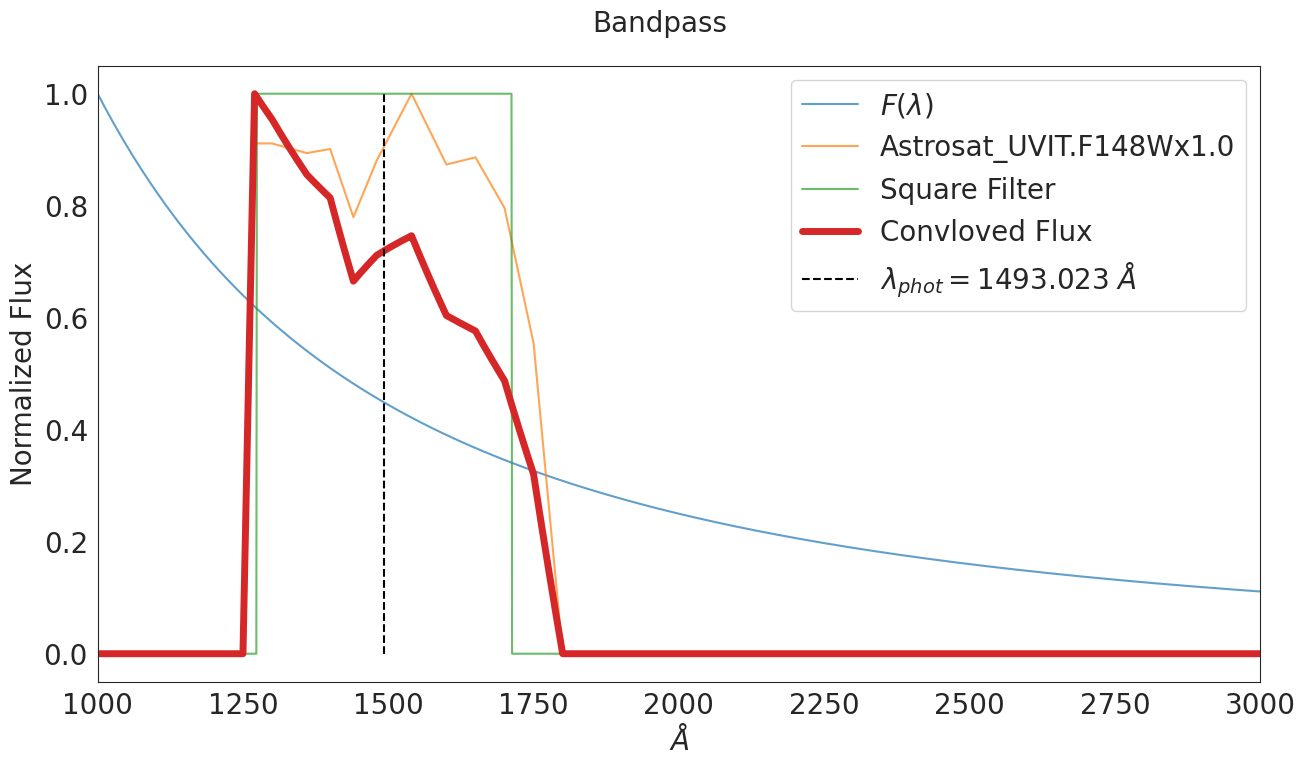

In [ ]:
fig, ax = plt.subplots(figsize = (15,8))
fig, ax, data, params = bandpass(wav, flux ,  inputs, True, fig, ax)
ax.set_xlim(1000,3000)

In [ ]:
lambda_, conv_flux, Reff = data

In [ ]:
lambda_phot, int_flux, int_flux_Jy, W_eff, flux_ratio  = params

tel_area = 1# np.pi*(240/2)**2
photons = 1.51e3*int_flux_Jy*(W_eff/lambda_phot)*tel_area*flux_ratio

In [ ]:
zp = 2.5*np.log10(photons)
zp

18.05929259665534

In [ ]:
assert np.round(zp,2)==18.06

In [ ]:
assert round(int_flux_Jy,0) == 3631

### **Generate PSF**

In [ ]:
params = {'sigma_x' : 0.8,
          'sigma_y' : 0.8,
          'gamma' : 1,
          'alpha' : 1}

In [ ]:
psf = generate_psf(101, params, 'Gaussian')
assert len(psf) == 101
psf = generate_psf(101, params, 'Moffat')
assert len(psf) == 101

### **Redshift Correction**

In [ ]:
wav = np.linspace(1500, 3000, 6000)
flux = models.Gaussian1D(1, 2250, 10)(wav)

In [ ]:
tab = Table()
tab['wav'] = [wav]
tab['flux'] = [flux]
tab['z1'] = 1
tab['z2'] = 1.1

In [ ]:
tab_out = redshift_corr(tab)

In [ ]:
wav_n = tab_out['wav'][0]
flux_n = tab_out['flux'][0]

In [ ]:
l0 = wav[np.where(flux==flux.max())[0][0]]
l1 = wav_n[np.where(flux_n==flux_n.max())[0][0]]

In [ ]:
assert np.round((l1-l0)/l0,2) == 0.1

In [ ]:
d1 = cosmo.luminosity_distance(1)
d2 = cosmo.luminosity_distance(1.1)

In [ ]:
assert flux_n.max()/flux.max() == (d1/d2)**2

### **Spectra to magnitude**

In [ ]:
wav = np.linspace(1000, 3000, 4000)
flux = models.Gaussian1D(1, 1500, 11)(wav)*1e-15

In [ ]:
tab = Table()
tab['wav'] = [wav,wav]
tab['flux'] = [flux,flux]
tab['z1'] = [1, 1]
tab['z2'] = [1, 1.1]

In [ ]:
inputs = [  '/content/INSIST/data/UVIT/filters/Astrosat_UVIT.F148W.dat,1,1',
        ]

In [ ]:
tab_new = spectra_to_mags_df(tab, inputs)

In [ ]:
assert (np.round(tab_new['mag'].value[0], 2) == 22.31)
assert (np.round(tab_new['mag'].value[1], 2) == 22.42)

## **Imager**

In [87]:
x = np.random.uniform(50,750,1000)
y = np.random.uniform(50,750,1000)
mag = np.random.uniform(20,30,1000)

df  = pd.DataFrame(zip(x,y,mag), columns = ['x','y','mag'])

In [88]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                 f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                  f'{data_path}/INSIST/UV/Filter.dat,1,100',

                                ],
             'coeffs'       : 1, #0.17
             'theta'        : 0
            }

In [89]:
sim = Imager(df = df, tel_params = tel_params, exp_time = 2400, plot = False
             ,n_x = 800, n_y = 800)

Converting xy to ra-dec


(<Figure size 1200x1000 with 2 Axes>,
 <Axes: title={'center': 'Requested Center :  RA : 10.0 degrees, Dec : 10.0 degrees | 1000 sources\n          Fov(RA) : 0.0222 (deg) | Fov(Dec) : 0.0222 (deg)'}, xlabel='RA (Degrees)', ylabel='Dec (Degrees)'>)

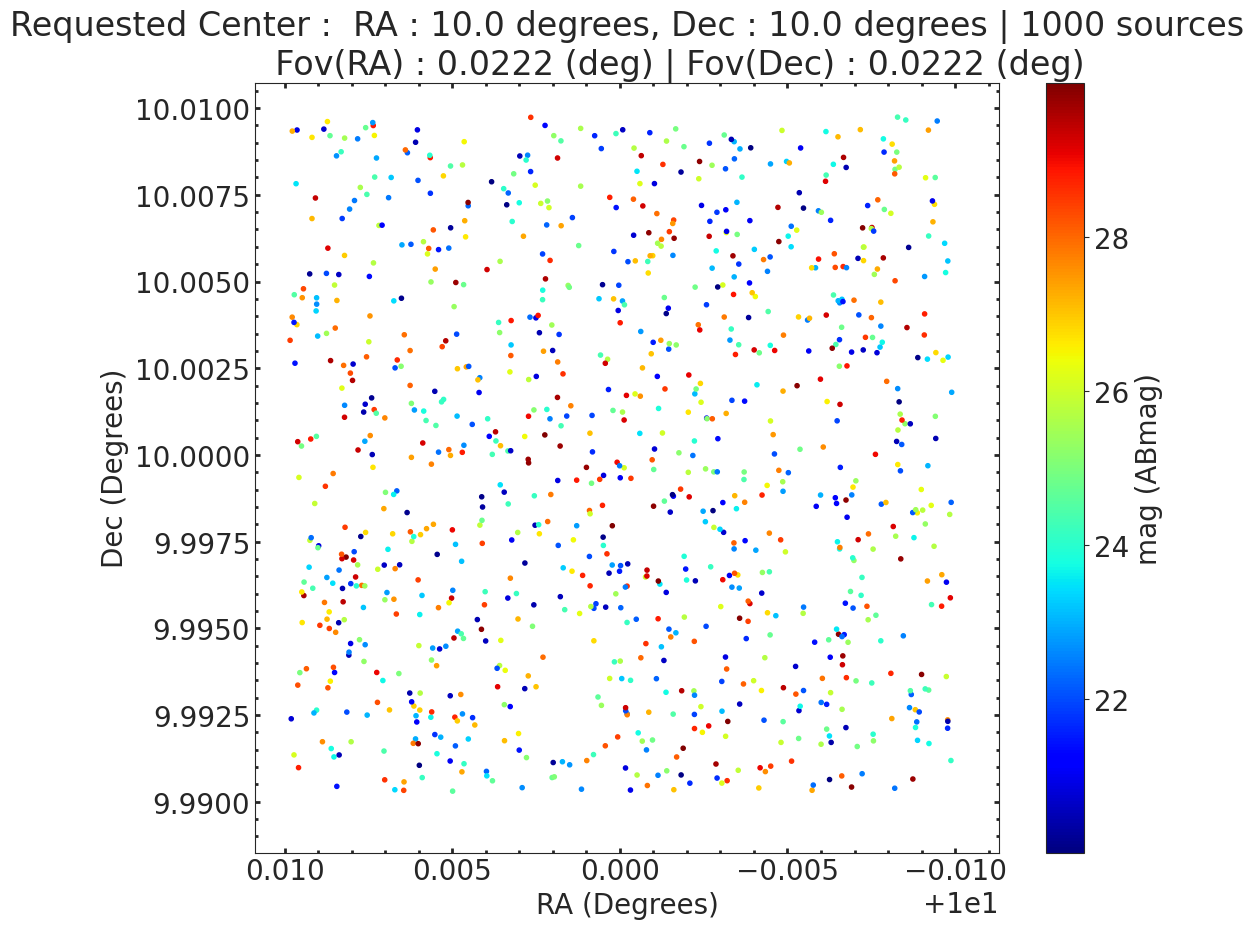

In [90]:
sim.show_field()

In [91]:
T = Gaussian2DKernel(1500,1500, x_size=sim.n_x, y_size=sim.n_y).array
T *= 218/T.max()

In [92]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [f'{data_path}/INSIST/UV/QE.dat,1,100'],
              'qe_mean'    : 1,
              'G1'         :  1,
              'bias'       :  5,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
sim.Cal0 = False
sim(det_params = det_params, photometry = 'PSF', detect_sources=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Performing photometry on Level 0 data


Fit source/group:   0%|          | 0/695 [00:00<?, ?it/s]

Model image:   0%|          | 0/699 [00:00<?, ?it/s]

In [ ]:
sim.show_image(overlay_apertures=True)

In [ ]:
sim.phot_table['mag']

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (35,10))
img = ax[0].imshow(sim.bias_frame, cmap='jet', norm=col.LogNorm())
img = ax[1].imshow(sim.dark_frame, cmap='jet')
img = ax[2].imshow(sim.flat_frame, cmap='jet', norm=col.LogNorm())

ax[0].set_title('Bias')
ax[1].set_title('Dark')
ax[2].set_title('Flat')

plt.colorbar(img, ax=ax)

Text(0, 0.5, 'Output (mag)')

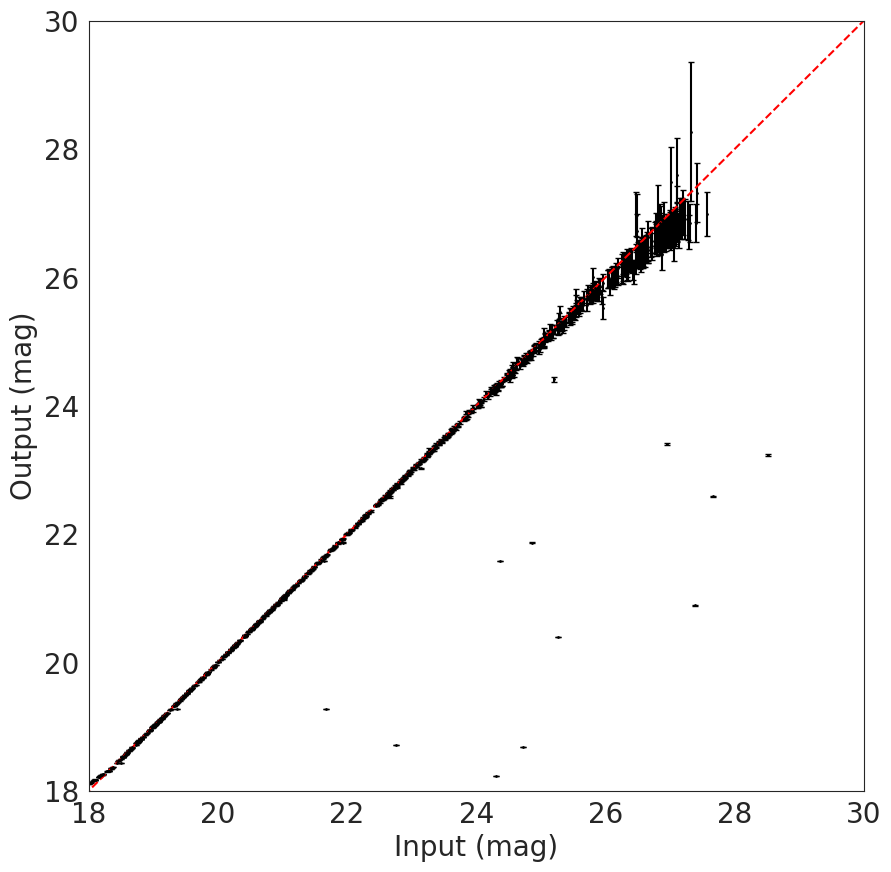

In [73]:
x = sim.phot_table['mag_in']
y = sim.phot_table['mag_out']
y_err = abs(sim.phot_table['mag_err'].value)
plt.errorbar(x, y, y_err, fmt='o', color = 'black', markersize=1, capsize=2)
plt.plot([5,30],[5,30],'--', color = 'red')
plt.xlim(18,30)
plt.ylim(18,30)
plt.xlabel('Input (mag)')
plt.ylabel('Output (mag)')

Text(0, 0.5, 'Out - Input (mag)')

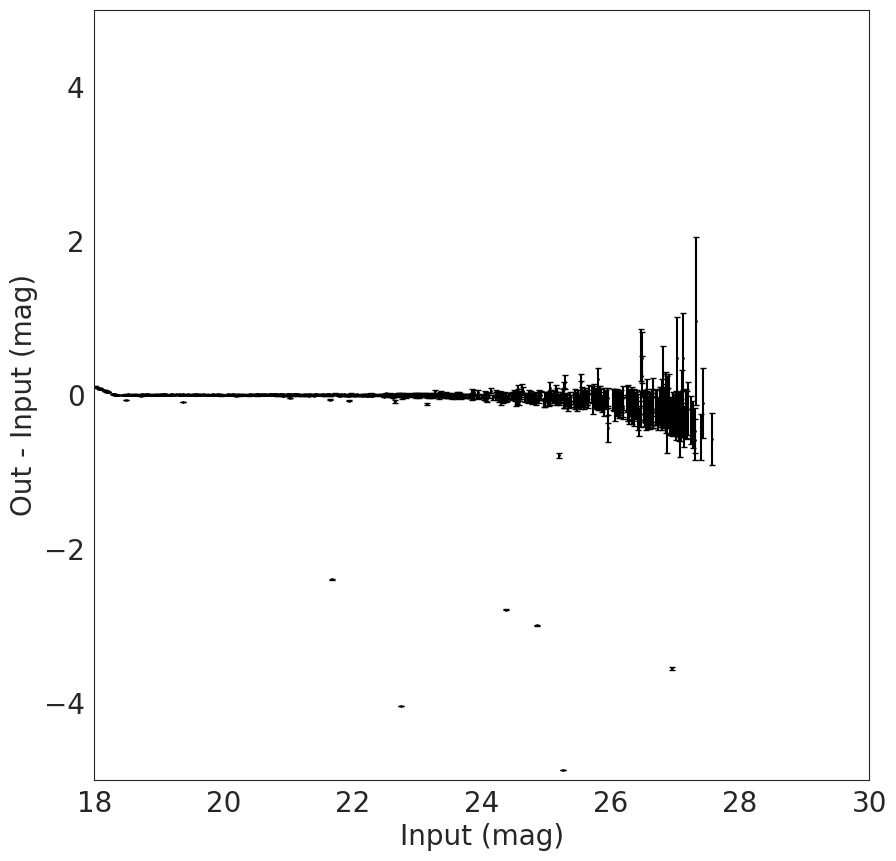

In [82]:
x = sim.phot_table['mag_in']
y = sim.phot_table['mag_out'] - sim.phot_table['mag_in']
y_err = abs(sim.phot_table['mag_err'].value)
plt.errorbar(x, y, y_err, fmt='o', color = 'black', markersize=1, capsize=2)
plt.xlim(18,30)
plt.ylim(-5,5)
plt.xlabel('Input (mag)')
plt.ylabel('Out - Input (mag)')

In [83]:
y.max()

0.9548001936816206

In [61]:
@custom_model
def pritchet(m,alpha=1,m_50=25):
  return 0.5*(1 - alpha*(m - m_50)/np.sqrt(1 + alpha**2*(m-m_50)**2))

In [85]:
y_in ,x = np.histogram(df['mag'], np.arange(18,28,0.5))
x = 0.5*(x[:-1]+x[1:])

temp = sim.phot_table[abs(sim.phot_table['mag_in']-sim.phot_table['mag_out'])<0.5]

y_out ,x = np.histogram(temp['mag_in'], np.arange(18,28,0.5))
x = 0.5*(x[:-1]+x[1:])

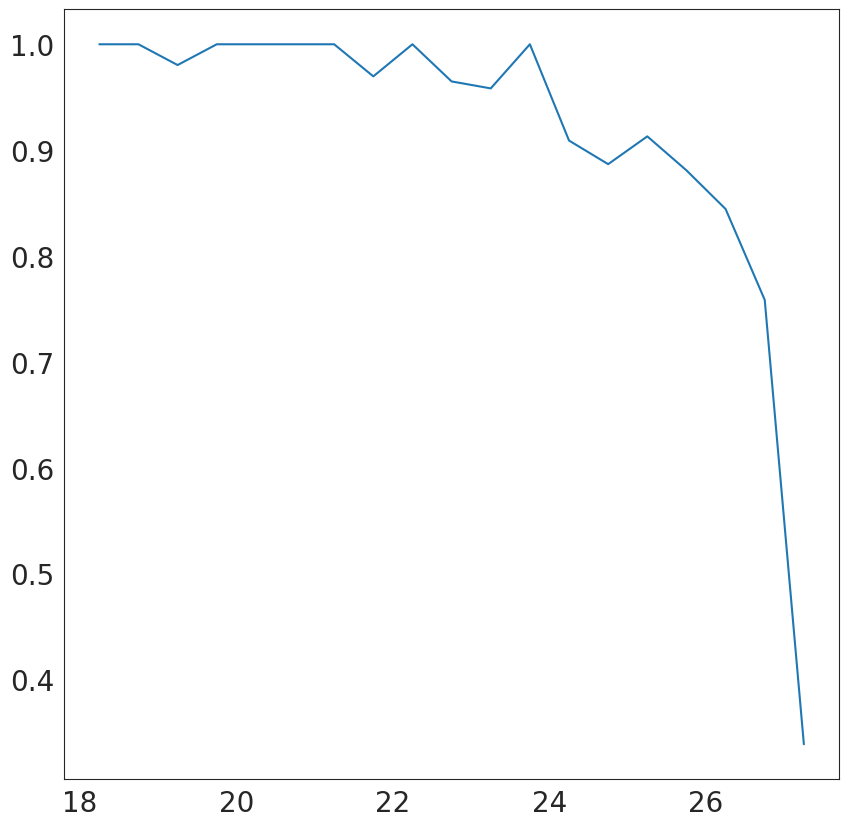

In [86]:
plt.plot(x,y_out/y_in)

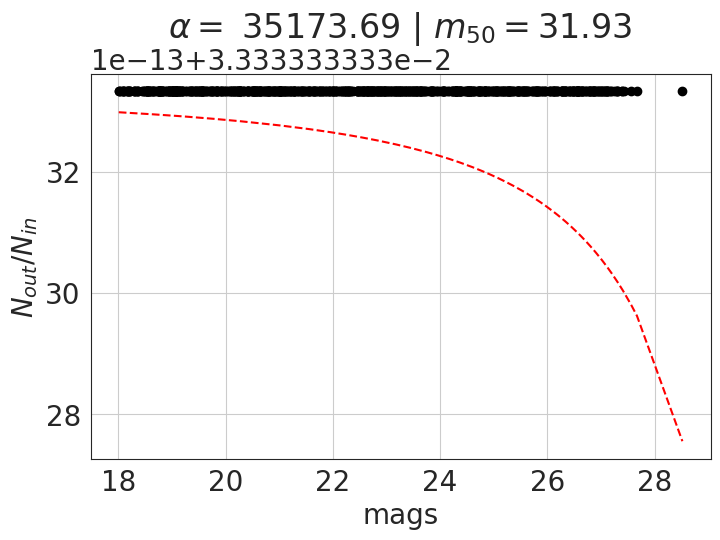

In [76]:
x = sim.phot_table.to_pandas().groupby('mag_in').count().index
x = np.array(x)
y = sim.phot_table.to_pandas().groupby('mag_in').count()['id']
y = np.array(y)/30

offset = y.max()

init = pritchet()
plt.figure(figsize=(8,5))
fit = fitting.LevMarLSQFitter()
model = fit(init, x, y/offset)
plt.plot(x,y,'ok')
plt.plot(x,model(x)*offset,'--r' )
plt.xlabel('mags')
plt.ylabel(r'$N_{out}/N_{in}$')
plt.title(r"$\alpha =$" + f" {np.round(model.alpha.value,2)}" + r" | $m_{50}=$" + f"{np.round(model.m_50.value,2)}")
plt.grid()

In [ ]:
output = sim.add_stars(np.zeros((800, 800)), 10**(0.4*sim.ZP), sim.df)

In [ ]:
plt.imshow(output, cmap='jet', norm = col.LogNorm() )

In [ ]:
df_phot = sim.phot_table.to_pandas()
df_phot = df_phot.dropna()

In [ ]:
x = df_phot['mag_in'].values
y = df_phot['SNR'].values
y_err = df_phot['mag_out'] - df_phot['mag_in']
im = plt.scatter(x,y,c = y_err, marker = '.', cmap = 'jet', vmin = 0,vmax = 0.5)
cb = plt.colorbar(im)
cb.set_label('Output-Input (mag)')
max_mag = np.round(x[np.where((y<5) & (~np.isnan(y)))[0][0]],3)
plt.title(f'Max depth for t = {sim.exp_time}s with SNR = 5 is {max_mag} mag')

plt.plot([22,30],[5,5],'--', color= 'black')

In [ ]:
height, width = sim.n_x,sim.n_y
xmap, ymap = np.meshgrid(np.arange(width), np.arange(height))
xmap = xmap + 0.05*np.sin(ymap / 20)
ymap = ymap + 0.05*np.cos(xmap / 20)

In [ ]:
sim.add_distortion(xmap,ymap)

In [ ]:
sim.show_image()

In [ ]:
sim.remove_distortion()

In [ ]:
sim.writecomp('test_comp.fits')

In [ ]:
sim.writeto('test.fits')

In [ ]:
del sim

In [ ]:
tab1 = Table.read('HST_INSIST_Off_axis_cross_match.fits')
tab2 = Table.read('HST_INSIST_On_axis_cross_match.fits')

In [ ]:
tab1['x_0'].max()

In [ ]:
plt.rcParams['text.latex.preamble'] = r'\boldmath'

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(25,10))

x = tab1['mag']
y = tab1['mag_out']
c = np.sqrt((tab1['x_0']-1250)**2 + (tab1['y_0']-1250)**2)

ax[0].plot([15,27], [15,27], '--', color='black')
img = ax[0].scatter(x,y,c=c,s=2, cmap='jet',marker = '.', zorder=111)

ax[0].set_xlim(15,26)
ax[0].set_ylim(15,26)

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax[0].tick_params(which='major', length=7,direction="in")
ax[0].tick_params(which='minor', length=4, color='black',direction="in")

ax[0].set_xlabel('HST (mag)')
ax[0].set_ylabel('INSIST (mag)')


x = tab2['mag']
y = tab2['mag_out']
c = np.sqrt((tab2['x_0']-1250)**2 + (tab2['y_0']-1250)**2)

ax[1].plot([15,27], [15,27], '--', color='black')
img = ax[1].scatter(x,y,c=c,s=2, cmap='jet',marker = '.', zorder=111)

ax[1].set_xlim(15,26)
ax[1].set_ylim(15,26)

ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

ax[1].tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax[1].tick_params(which='major', length=7,direction="in")
ax[1].tick_params(which='minor', length=4, color='black',direction="in")

ax[1].set_xlabel('HST (mag)')
ax[1].set_ylabel('INSIST (mag)')

cb = plt.colorbar(img, ax=ax, pad = 0.01)
cb.set_label('Distance from center of the luster (pix)')

## **Mosaic**

In [ ]:
y,x = 2*np.mgrid[0:100,0:100]/3600

ra  = 10 + x.ravel()
dec = 10 + y.ravel()
mag = np.linspace(22,30,10000)
df  = pd.DataFrame(zip(ra,dec,mag), columns = ['ra','dec','mag'])

In [ ]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
             'coeffs'       : 1, #0.17
             'theta'        : 0
            }

In [ ]:
mos = Mosaic(df = df, tel_params = tel_params, exp_time = 2400,
             n_x = 2000, n_y = 2000, mos_n = 2, mos_m = 2)

In [ ]:
mos.show_field()

In [ ]:
det_params = {'shot_noise' :  'Gaussian',
              'G1'         :  1,
              'qe_response': [],
              'PRNU_frac'  :  0.25/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
                     }

In [ ]:
mos(det_params = det_params)

In [ ]:
mos.make_mosaic()

In [ ]:
mos.show_image()

## **Spectroscopy**

In [ ]:
x = np.arange(1500,3000,0.1)
y = models.Gaussian1D(mean = 2250, stddev = 300)(x)
dat = np.stack([x,y]).T

In [ ]:
np.savetxt('Grating.dat',dat)

In [ ]:
input_g = [
            f'{data_path}/INSIST/G/M1.dat,5,100',   # 6 mirrors
            f'{data_path}/INSIST/G/Filter.dat,1,100',
            f'{data_path}/INSIST/G/Dichroic.dat,1,100'
          ]

input_U = [
              f'{data_path}/INSIST/U/M1.dat,5,100',   # 6 mirrors
              f'{data_path}/INSIST/U/Filter.dat,1,100',
              f'{data_path}/INSIST/U/Dichroic.dat,2,100'
            ]

input_UV = [
            f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
            f'{data_path}/INSIST/UV/Filter.dat,1,100',
            f'{data_path}/INSIST/UV/Dichroic.dat,2,100'
          ]

In [ ]:
tel_params = {
                'aperture'    : 100,
                'pixel_scale' : 0.1,
                'psf_file'    : f'{data_path}/PSF/INSIST/off_axis_Zmax.npy',

                'response_funcs' : input_UV,
                'coeffs '  : 1,
                'theta'    : 0,
                'dellambda': 1,
                'lambda1'  : 1500,
                'lambda2'  : 3001
            }

### **Example Input**

In [ ]:
wav = np.arange(1200, 3200, 0.1)
flux = models.Gaussian1D(1, 1500, 5)(wav)*1e-13
flux += models.Gaussian1D(1, 2000, 5)(wav)*1e-13
flux += models.Gaussian1D(1, 2250, 5)(wav)*1e-13
flux += models.Gaussian1D(1, 2500, 5)(wav)*1e-13
flux += models.Gaussian1D(1, 3000, 5)(wav)*1e-13
flux += 1e-14

In [ ]:
df_spec = Table()
df_spec['wav'] = [wav, wav + 100, wav]
df_spec['flux'] = [flux, flux, wav*0 + 1e-13]
df_spec['x'] = [3450, 3450, 3450]
df_spec['y'] = [1000, 1200, 1400]
df_spec['z1'] = [1, 1, 1]
df_spec['z2'] = [1, 1, 1]

### **Kurucz Model**

In [ ]:
!unzip sed_models

In [ ]:
model_tab = Table.read('kurucz_models.fits')

In [ ]:
tab = Table.read('M31_subsample.fits')[['ra','dec', 'Md','id','T','logg','Met']]
wav = np.loadtxt('kurucz_wav.dat')

In [ ]:
tab = tab[:3]

In [ ]:
fluxes = []

for id in tab['id'][:1]:
  id = id.split()[0]
  flux = model_tab[model_tab['INDEX']==id]['model_flux'].value[0]
  fluxes.append(flux)

In [ ]:
g = []
UV = []
U = []

for flux in fluxes:

  m = spectra_to_mags(wav, flux, input_g, 1,1)
  g.append(m)

  m = spectra_to_mags(wav, flux, input_UV, 1,1)
  UV.append(m)

  m = spectra_to_mags(wav, flux, input_U, 1,1)
  U.append(m)

In [ ]:
g = np.array(g) + 2.5*(tab['Md']-4)
U = np.array(U) + 2.5*(tab['Md']-4)
UV = np.array(UV) + 2.5*(tab['Md']-4)

In [ ]:
df_img = tab[['ra','dec']].to_pandas()

In [ ]:
#df_img['INSIST_g'] = g
#df_img['INSIST_U'] = U
#df_img['INSIST_UV'] = UV
df_img['mag'] = UV

In [ ]:
df_spec = tab

In [ ]:
df_spec['flux'] = fluxes
df_spec['wav'] = [wav]
df_spec['z1'] = 1
df_spec['z2'] = 1
df_spec['mag'] = UV

In [ ]:
df_spec['flux'] = df_spec['flux']*10**(-df_spec['Md'].value.reshape(-1,1)+4)

### **Slitless**

In [ ]:
spec_inputs = ['Grating.dat,1,1',
               f'{data_path}/INSIST/UV/QE.dat,1,100']

tel_params_spec = {
                'aperture'    : 100,
                'pixel_scale' : 0.1,
                'psf_file'    : f'{data_path}/PSF/INSIST/off_axis_Zmax.npy',

                'response_funcs' : input_UV + spec_inputs,
                'coeffs '  : 1,
                'theta'    : 0,
                'dellambda': 4/3,
                'lambda1'  : 1500,
                'lambda2'  : 2999
            }

In [ ]:
sim_spec = Spectrograph(df=df_spec, tel_params=tel_params_spec,
                        exp_time=1000, n_x = 6900, n_y = 2400)

In [ ]:
sim_spec.show_field()

In [ ]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],# [f'{data_path}/INSIST/UV/QE.dat,1,100'],
              'qe_mean'    : 0.95,
              'G1'         :  1,
              'bias'       : 10,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
sim_spec(det_params=det_params, spectroscopy = True)

In [ ]:
sim_spec.show_image(figsize = (15,5), cmap = 'gray')

In [ ]:
z = zip(sim_spec.img_df['wav'], sim_spec.img_df['flux'], sim_spec.phot_table['flux'] )

for wav, in_flux, out_flux in z:
  plt.figure(figsize = (15,8))
  binned_input = sim_spec.bin_xy(wav, in_flux)
  flux = out_flux/sim_spec.UC
  plt.plot(sim_spec.spec_bins, flux, marker = '.',)
  plt.plot(sim_spec.spec_bins, binned_input, color='black')
  plt.legend([ 'Calibrated Spectra', 'Binned Input',])
  plt.xlabel(r'Wavelength ($\AA$)')
  plt.ylabel(r'Flux ($ergs.s^{-1}.cm2^{-2}.\AA^{-1})$')
  plt.show()

In [ ]:
plt.scatter(sim_spec.spec_bins, flux)

#### **IUE**

In [ ]:
with open('lr09295.txt', 'r') as f:
  dat = f.readlines()

In [ ]:
flux = []
for i in dat[19:]:
  flux.append([float(j) if abs(float(j))!=1 else 0 for j in i.split() ])
flux = np.array(flux)

In [ ]:
wav = 0.1*np.arange(0,12250,1) + 1900

In [ ]:
f = flux[:,0]
f -= f.min()

In [ ]:
plt.plot(wav,f)

In [ ]:
ra = [0., 0, 0,0]
dec= [0., 5/3600, 10/3600, 15/3600 ]
wav_ = [wav,wav,wav,wav]
fluxes = [f,f,f,f]
d1     = [140, 140, 140, 140]
d2     = [140, 140, 140, 400] #[0.001, 0.0011, 0.012, 0.013]
df_spec = Table([ra,dec,wav_,fluxes,d1,d2],
                names = ['ra','dec', 'wav','flux','d1','d2'])

In [ ]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       :    f'{data_path}/data/PSF/INSIST/off_axis_Zmax.npy',

            'response_funcs' :  [ f'{data_path}/data/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/data/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                  f'{data_path}/data/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                   'Grating.dat,1,1'
                                ],
             'coeffs '  : 0.17,
             'theta'    : 0,
             'dellambda': 1,
             'lambda1'  : 1900,
             'lambda2'  : 3000

            }

In [ ]:
df_img = spectra_to_mags(df_spec, tel_params['response_funcs']).to_pandas()

In [ ]:
df_img

In [ ]:
sim_img = Imager(df = df_img, tel_params = tel_params,
                   exp_time = 1, n_x = 2000, n_y = 2000)
sim_spec = Spectrometer(df = df_spec, tel_params = tel_params,
                   exp_time = 1, n_x = 2000, n_y = 2000)
sim_img()
sim_spec()

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (20,9))
fig, ax[0] = sim_img.show_image(fig = fig, ax = ax[0])
fig, ax[1] = sim_spec.show_image(fig = fig, ax = ax[1])

In [ ]:
sim_spec.generate_cal_flux(source_indices = [0,1,2])

In [ ]:
sim_spec.exp_time

In [ ]:
z = zip(sim_spec.img_df['wav'], sim_spec.img_df['flux'], sim_spec.phot_table['flux'] )

for wav, in_flux, out_flux in z:
  out_flux = out_flux*sim_spec.cal_flux

  binned_input = sim_spec.bin_xy(wav, in_flux)
  plt.plot(sim_spec.spec_bins, out_flux,'--')

  plt.plot(sim_spec.spec_bins, binned_input)
  plt.legend(['Calibrated Spectra', 'Binned Input'])
  plt.xlabel(r'Wavelength ($\AA$)')
  plt.ylabel(r'Flux ($ergs.s^{-1}.cm2^{-2}.\AA^{-1})$')
  plt.xlim(2700,2900)
  plt.show()
  break

### **Multi-Object Spectroscopy**

In [ ]:
calc_mos_size(2340,1140,45,4501)

In [ ]:
sim_spec = Spectrograph(df=df_spec,tel_params=tel_params_spec,
                        exp_time=2400, n_x = 8000, n_y = 2500)

In [ ]:
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['figure.labelsize'] = 'x-large'

In [ ]:
sim_spec.show_field(figsize = (10,6))

In [ ]:
sim_spec.init_MOS(2340,1140,45)

In [ ]:
sim_spec.show_field(figsize = (10,6))

In [ ]:
res_df = None

In [ ]:
mos_df, res_df, _,_ = sim_spec.select_MOS_sources(df = res_df)

In [ ]:
sim_spec.show_field(figsize = (10,6))

In [ ]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 1,
              'G1'         :  1,
              'bias'       : 10,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
sim_spec(det_params=det_params)

In [ ]:
sim_spec.show_image()

In [ ]:
z = zip(sim_spec.img_df['wav'], sim_spec.img_df['flux'], sim_spec.phot_table['flux'] )
plt.figure(figsize = (15,8))
for wav, in_flux, out_flux in z:
  binned_input = sim_spec.bin_xy(wav, in_flux)
  flux = sim_spec.cal_flux(out_flux, A = -1, B=0.1)
  plt.plot(sim_spec.spec_bins, flux)
  plt.plot(sim_spec.spec_bins, binned_input, '--', color='black')
  plt.legend(['Binned Input', 'Calibrated Spectra', ])
  plt.xlabel(r'Wavelength ($\AA$)')
  plt.ylabel(r'Flux ($ergs.s^{-1}.cm2^{-2}.\AA^{-1})$')
  plt.show()

In [ ]:

sim_spec.writecomp('mos.fits')

## **Galaxy**

In [ ]:
# Coma cluster properties
cluster_center_ra = 194.9558  # RA of the Coma cluster center
cluster_center_dec = 27.9807  # Dec of the Coma cluster center
cluster_size_arcsec = 2/60 # Size of the Coma cluster in arcseconds
num_galaxies = 100  # Number of galaxies to generate

# Generate galaxy positions using a Gaussian distribution
np.random.seed(42)

ra = np.random.normal(cluster_center_ra, cluster_size_arcsec / np.sqrt(8*np.log(2)), num_galaxies)
dec = np.random.normal(cluster_center_dec, cluster_size_arcsec / np.sqrt(8*np.log(2)), num_galaxies)
mag = np.random.uniform(16, 20, num_galaxies)

# Generate parameters for bulge, bar, and disk components
bulge_M = np.random.uniform(18, 19, num_galaxies)
bulge_Re = np.random.uniform(0.2, 1.0, num_galaxies)
bulge_n = np.random.uniform(1.0, 4.0, num_galaxies)
bulge_ba = np.random.uniform(0.5, 0.9, num_galaxies)
bulge_pa = np.random.uniform(0, 180, num_galaxies)

bar_M = np.random.uniform(17, 18, num_galaxies)
bar_Re = np.random.uniform(1.0, 3.0, num_galaxies)
bar_n = np.random.uniform(0.4, 1.0, num_galaxies)
bar_ba = np.random.uniform(0.3, 0.7, num_galaxies)
bar_pa = np.random.uniform(0, 180, num_galaxies)

disk_M = np.random.uniform(16, 17, num_galaxies)
disk_Re = np.random.uniform(2.0, 4.0, num_galaxies)
disk_n = np.random.uniform(0.8, 1.2, num_galaxies)
disk_ba = np.random.uniform(0.6, 0.95, num_galaxies)
disk_pa = np.random.uniform(0, 180, num_galaxies)

# Create the DataFrame for galaxy cluster
df = pd.DataFrame({'ra': ra, 'dec': dec, 'mag': mag,
                   'bulge_M': bulge_M, 'bulge_Re': bulge_Re, 'bulge_n': bulge_n,
                   'bulge_ba': bulge_ba, 'bulge_pa': bulge_pa,
                   'bar_M': bar_M, 'bar_Re': bar_Re, 'bar_n': bar_n,
                   'bar_ba': bar_ba, 'bar_pa': bar_pa,
                   'disk_M': disk_M, 'disk_Re': disk_Re, 'disk_n': disk_n,
                   'disk_ba': disk_ba, 'disk_pa': disk_pa})

In [ ]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                  f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
             'coeffs'       : 1,
             'theta'        : 0
            }

In [ ]:
sim = Galaxy(df = df, coords = (cluster_center_ra, cluster_center_dec),
             tel_params = tel_params, exp_time = 2400, plot = False,
             n_x = 6000, n_y = 6000)

In [ ]:
sim.show_field()

In [ ]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],# [f'{data_path}/INSIST/UV/QE.dat,1,100'],
              'qe_mean'    : 0.95,
              'G1'         :  1,
              'bias'       : 10,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
sim(det_params=det_params)

In [ ]:
sim.show_image()

# **Critical Checks**

## **INSIST Vs UVIT Vs GALEX**

In [ ]:
data_git = '/content/INSIST/data'

In [ ]:
df = pd.read_csv(f'{data_path}/sample2.csv')

In [ ]:
df = df.rename(columns = {'F275W':'mag'})

In [ ]:
tel_params_insist = {
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 5 mirrors
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
            }
tel_params_uvit = {
            'aperture'       : 1,
            'pixel_scale'    : 3.33/8,
            'psf_file'       : f'{data_git}/UVIT/PSF/on_axis_hcipy.npy',
            'response_funcs' :  [ f'{data_git}/UVIT/filters/Astrosat_UVIT.N279N.dat,1,1'
                                ],
            'coeffs'         : 1/(np.pi*0.5**2)
            }

tel_params_galex = {
            'aperture'       : 1,
            'pixel_scale'    : 1.5,
            'psf_file'       : f'{data_git}/GALEX/PSF/PSFnuv_faint.fits',
            'response_funcs' :  [ f'{data_git}/GALEX/filters/GALEX_GALEX.FUV.dat,1,1'
                                ],
            'coeffs'         : 1/(np.pi*0.5**2)
                  }

In [ ]:
det_params_insist = {'shot_noise': 'Poisson',
                    'bias': 35,
                    'G1': 1,
                    'qe_resonse' : [f'{data_path}/data/INSIST/UV/QE.dat,1,100'],
                    'bit_res': 14,
                    'RN': 5,
                    'PRNU_frac': 0.0025,
                    'T': 218,
                    'DFM': 0.01424,
                    'pixel_area': 1e-06,
                    'DN': 0.001,
                    'NF': 12,
                    'FWC': 140000.0,
                    'C_ray_r': 0.04}

det_params_uvit  = {'shot_noise': 'Poisson',
                    'bias': 100,
                    'G1': 1,
                    'bit_res': 14,
                    'RN': 5,
                    'PRNU_frac': 0.0025,
                    'T': 293,
                    'DFM': 0.004624,
                    'pixel_area': (25/8)*1e-6,
                    'DN': 0.001,
                    'NF': 0,
                    'FWC': 150000.0}

det_params_galex = {'shot_noise': 'Poisson',
                    'bias': 35,
                    'G1': 1,
                    'bit_res': 14,
                    'RN': 5,
                    'PRNU_frac': 0.0025,
                    'T': 293,
                    'DFM': 0.01424,
                    'pixel_area': (25/8)*1e-06,
                    'DN': 0.001,
                    'NF': 0,
                    'FWC': 140000.0}

In [ ]:
df_galex  = df[df['mag']<25]
df_uvit   = df[df['mag']<27]
df_insist = df[df['mag']<28]

In [ ]:
sim_insist = Imager(df = df_insist,
                     tel_params = tel_params_insist, n_x = 800, n_y = 800,
                     exp_time = 2000)
sim_uvit   = Imager(df = df_uvit, coords = (sim_insist.ra, sim_insist.dec),
                      tel_params = tel_params_uvit, n_x = 192, n_y = 192,
                      exp_time = 10000)
sim_galex  = Imager(df = df_galex, coords = (sim_insist.ra, sim_insist.dec),
                        tel_params = tel_params_galex, n_x = 53, n_y = 53,
                        exp_time = 2000)

In [ ]:
sim_insist(det_params = det_params_insist)
sim_uvit.DC = False
sim_uvit(det_params = det_params_uvit)
sim_galex.DC = False
sim_galex(det_params = det_params_galex)

In [ ]:
fig, ax = sim_insist.show_image(cmap = 'gray')
fig.suptitle('INSIST | Source:  NGC 1851 | Filter: UV | FoV: 80 arcsecs | Exptime: 2000 secs')

In [ ]:
fig,ax = sim_uvit.show_image(cmap='gray')
fig.suptitle('UVIT | Source: NGC 1851 | Filter: N263W | FoV: 80 arcsecs | Exptime: 2000 secs')

In [ ]:
sim_uvit.writeto('NGC_1851_UVIT.fits')
sim_insist.writeto('NGC_1851_INSIST.fits')

In [ ]:
fig,ax = sim_galex.show_image(cmap='gray')
fig.suptitle('GALEX | Source:  NGC 1851 | Filter: NUV | FoV: 80 arcsecs | Exptime: 2000 secs')

In [ ]:
#

# **HST**

In [ ]:
data_git = '/content/INSIST/data'

In [ ]:
df = pd.read_csv(f'{data_path}/data/sample2.csv')

In [ ]:
df = df.rename(columns = {'F275W':'mag'})

In [ ]:
tel_params_hst = {
            'aperture'       : 240,
            'pixel_scale'    : 0.04,
            'psf_file'       : f'{data_git}/HST/PSF/F275.fits',
            'response_funcs' :  [ f'{data_git}/HST/filters/HST_WFC3_UVIS1.F275W.dat,1,1'
                                ],
            }

In [ ]:
sim_hst = Imager(df = df,
                     tel_params = tel_params_hst, n_x = 8000, n_y = 8000,
                     exp_time = 1288)

In [ ]:
sim_hst(photometry='PSF', fwhm = 5)

In [ ]:
sim_hst.show_image()

In [ ]:
sim_hst.phot_table

In [ ]:
sim_hst.img_df

# **Optimization**

## **Rotational Orientation Optimization**

In [ ]:
opt = []
for i in range (0,180,1):
  tel_params['theta'] = i
  sim_spec = Spectrometer(df = df_spec, tel_params = tel_params,
                    exp_time = 2400, n_x = 2000, n_y = 2000)

  sim_spec()
  mask = sim_spec.mask
  mask = np.where(mask>=1,mask,0)
  opt.append([i,mask.sum()])

In [ ]:
opt = np.array(opt)

In [ ]:
angles = opt[:,0]
op_frac = opt[:,1]
angles[np.where(op_frac==op_frac.min())[0]]

In [ ]:
plt.plot(angles, op_frac)
plt.xlabel('Angle')
plt.ylabel('Overlap Metric')

## **Dynamic Range Vs Exposure time**

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [ ]:
y,x = 2*np.mgrid[0:100,0:100]/3600

ra  = 10 + x.ravel()
dec = 10 + y.ravel()
mag = np.linspace(8,30,10000)
df  = pd.DataFrame(zip(ra,dec,mag), columns = ['ra','dec','mag'])

In [ ]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                  f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
             'coeffs'       : 1,
             'theta'        : 0
            }
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 0.95,
              'G1'         :  1,
              'bias'       :  50,
              'PRNU_frac'  :  0.25/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
t_min_mags = []
t_max_mags = []
t_del_mags = []

min_mags = []
max_mags = []
del_mags = []

ts = np.logspace(0,3,100)
for exp_time in ts:
  sim = Imager(df = df, tel_params = tel_params, exp_time = exp_time,
              plot = False, n_x = 2000,n_y = 2000)
  sim(det_params = det_params, photometry = 'Aper', fwhm = 2,
    detect_sources  = False, n_stack = 1)

  F0 = 10**(0.4*sim.ZP)

  max_mag = -2.5*np.log10(50/F0)
  min_mag = -2.5*np.log10(88833/F0)

  del_mag = max_mag - min_mag

  t_min_mags.append(min_mag)
  t_max_mags.append(max_mag)
  t_del_mags.append(del_mag)

  tab = sim.phot_table[sim.phot_table['SNR']>50]
  x = tab['mag_in'].value
  y = tab['mag_out'].value
  min_mag = x[np.where(y> x+0.1)[0][-1]]

  x = sim.phot_table['mag_in']
  y = sim.phot_table['SNR']

  max_mag = np.round(x[np.where(y<5)[0][0]],3)

  del_mag = max_mag - min_mag

  min_mags.append(min_mag)
  max_mags.append(max_mag)
  del_mags.append(del_mag)

In [ ]:
from astropy.modeling.models import custom_model

In [ ]:
def mag_fit(t,C=10):
  return 2.5*np.log10(t) + C

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (30,5))
x = ts
y = min_mags

init = models.custom_model(mag_fit)()
fit = fitting.LevMarLSQFitter()
model = fit(init, x, y)

ax[0].plot(x,y,'-ko')
ax[0].plot(x,model(x), 'r-')
ax[0].set_title(f'Saturation Limit | C: {np.round(model.C.value,2)}')
ax[0].set_xlabel('Exposure Time (s)')
ax[0].set_ylabel('Magnitude (AB mag)')


y = max_mags
init = models.custom_model(mag_fit)()
fit = fitting.LevMarLSQFitter()
model = fit(init, x, y)

ax[1].plot(x,y,'-ko')
ax[1].plot(x,model(x), 'r-')
ax[1].set_title(f'Limiting Magnitude | C: {np.round(model.C.value,2)}')
ax[1].set_xlabel('Exposure Time (s)')
ax[1].set_ylabel('Magnitude (AB mag)')

y = del_mags
init = models.Polynomial1D(2)
fit = fitting.LevMarLSQFitter()
model = fit(init, x, y)
ax[2].plot(x,y,'-ko')
ax[2].plot(x,model(x), 'r-')

c0 = np.round(model.c0.value,5)
c1 = np.round(model.c1.value,5)
c2 = model.c2.value

ax[2].set_title(f'Dynamic Magnitude Range \n c0: {c0}, c1: {c1}, c2: {c2:e}')
ax[2].set_xlabel('Exposure Time (s)')
ax[2].set_ylabel('Magnitude (AB mag)')

for i in range(3):
  ax[i].xaxis.set_minor_locator(AutoMinorLocator())
  ax[i].yaxis.set_minor_locator(AutoMinorLocator())


  ax[i].tick_params(which='both', width=2,direction="in", top = True,right = True,
                bottom = True, left = True)
  ax[i].tick_params(which='major', length=7, direction="in")
  ax[i].tick_params(which='minor', length=4, color='black',direction="in")

## **Multi-Object Spectroscopy**

In [ ]:
def t_range(m, C1=9.68, C2=17.44):

  t_max = 10**((m-C1)/2.5)
  t_min = 10**((m-C2)/2.5)

  return t_min, t_max

In [ ]:
# Exposure Bracketing
def exp_brac(t0,t1):
  ts = []
  for i in range(len(t0)-1):
    t = 0.5*(t1[i] + t0[i+1])
    ts.append(t)
  return ts

In [ ]:
def count_sources_within_radius(catalog, radius):
    tree = cKDTree(catalog)
    counts = []

    for star in catalog:
        indices = tree.query_ball_point(star, radius)
        count = len(indices) - 1  # Exclude the star itself from the count
        counts.append(count)

    return counts

In [ ]:
df = Table.read(f'{data_path}/sample.fits').to_pandas()

In [ ]:
mag_bins = np.arange(df.mag.min(), df.mag.max(), 7)

In [ ]:
t0,t1 = t_range(mag_bins)

In [ ]:
ts = exp_brac(t0, t1)

In [ ]:
df_bracs = []
for i in range(len(mag_bins)-1):
  c1 = df['mag'] >= mag_bins[i]
  c2 = df['mag'] < mag_bins[i+1]
  df_bracs.append(df[c1 & c2])

In [ ]:
df_1 = df_bracs[0]

In [ ]:
x = df_1['ra']
y = df_1['dec']
plt.scatter(x,y, s = 1, color = 'black')

In [ ]:
tel_params ={
            'aperture'       : 100,
            'pixel_scale'    : 0.1,
            'psf_file'       : f'{data_path}/PSF/INSIST/off_axis_poppy.npy',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                  f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                ],
             'coeffs'       : 1,
             'theta'        : 0
            }
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 0.95,
              'G1'         :  1,
              'bias'       :  50,
              'PRNU_frac'  :  0.25/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
sim = Imager(df = df_1, tel_params = tel_params, exp_time = ts[0],
            plot = False, n_x = 500,n_y = 500)
sim(det_params = det_params, photometry = 'Aper', fwhm = 2,
  detect_sources  = False, n_stack = 1)

In [ ]:
sim.show_image()

In [ ]:
x = sim.phot_table['mag_in']
y = sim.phot_table['mag_out']
y_err = abs(sim.phot_table['mag_err'])
plt.errorbar(x,y,yerr= y_err,fmt='o', color = 'black', markersize=2, capsize=3)
plt.plot([5,30],[5,30],'--', color = 'red')
plt.xlim(5,30)
plt.ylim(5,30)
plt.xlabel('Input (mag)')
plt.ylabel('Output (mag)')

In [ ]:
c

In [ ]:
x = sim.phot_table['ra']
y = sim.phot_table['dec']
c = sim.phot_table['mag_err']
s = sim.phot_table['mag_in']

fig, ax = plt.subplots()
img = ax.scatter(x,y,c=c, s=s, cmap = 'jet', vmin = 0.5, vmax = 2)
plt.colorbar(img)

In [ ]:
def select_mos(df, cen_x, cen_y, ids = [], radius = 10, min_sep = 10):

  catalog = df[['x', 'y']].values
  result = count_sources_within_radius(catalog, radius)
  df['n_density'] = result

  top = np.flip(np.arange(cen_y, 0, -min_sep))
  bottom = np.arange(cen_y + min_sep, sim.n_y, min_sep)

  y_pos = np.concatenate([top, bottom])
  mos_df = []
  df['x_sep'] = abs(df['x']- cen_x)
  for i in y_pos:
    p = df[(df['y']>i-2) & (df['y']<i+2)]
    p = p[p['n_density']==0]

    if len(p)>0:
      p = p[p['x_sep']==p['x_sep'].min()]
      mos_df.append(p.values[0])

  mos_df = pd.DataFrame(mos_df, columns = df.keys())

  res_df = mos_df[0:0]
  for id in df['objid']:
    if id not in mos_df['objid'].values or id in ids:
      t = df[df['objid']==id]
      res_df = pd.concat([res_df,t])

  return mos_df, res_df, cen_x, cen_y

In [ ]:
fig, ax = plt.subplots(1,9, figsize = (50,5), sharey = True)

img_df = sim.img_df
img_df['objid'] = np.arange(0., len(img_df), 1.)
res_df = img_df
ids = []
mos_dfs = res_df[0:0]
for i in range(len(ax)):

  x = res_df['x'].values
  y = res_df['y'].values

  cen_x = x[np.argmin(abs(x-np.mean(x)))]
  cen_y = y[np.argmin(abs(y-np.mean(y)))]

  mos_df, res_df, cen_x, cen_y = select_mos(res_df, cen_x, cen_y, ids,
                                            radius=1.5, min_sep = 6)
  ax[i].hlines(y = mos_df['y'],
            xmin= 0, xmax= sim.n_x,
            color = 'k', linestyle = '-', linewidth = 3)
  ax[i].scatter(mos_df['x'], mos_df['y'], marker = 'o', zorder = 101,
              color = 'red')
  ax[i].scatter(cen_x, cen_y, marker = '+', color='blue', linewidth = 5,
              zorder = 102)
  ax[i].set_title(f'Number of source: {len(mos_df)}')

  mos_dfs = pd.concat([mos_dfs, mos_df])
  ids += list(mos_df['objid'].values)

plt.subplots_adjust(wspace=0.01)

In [ ]:
plt.scatter(mos_dfs['x'], mos_dfs['y'])
plt.scatter(res_df['x'], res_df['y'])

plt.legend(['Observed','Residual'])

In [ ]:
len(mos_dfs),len(res_df)

In [ ]:
for id in img_df['objid']:
  if id not in mos_df['objid'].values or id not in ids:
    print(id)


## **INSIST-HST Bootstrap**

In [ ]:
df_img = pd.read_csv('M31_INSIST_PSC_Full.csv')

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
df_s = df_img.copy()
df_s['diff'] = np.abs(df_s['HST_f275w'] - df_s['HST_f275w_p'])
df_s = df_s[df_s['diff']<0.1]

In [ ]:
x1 = df_s['HST_f275w'].values
x2 = df_s['HST_f336w'].values
x3 = df_s['HST_f475w'].values
x4 = df_s['HST_f1100w'].values
x5 = df_s['HST_f1600w'].values


x6 = df_s['HST_f275w'].values - df_s['HST_f336w'].values
x7 = df_s['HST_f275w'].values - df_s['HST_f475w'].values
x8 = df_s['HST_f275w'].values - df_s['HST_f1100w'].values
x9 = df_s['HST_f275w'].values - df_s['HST_f1600w'].values
x10 = df_s['HST_f336w'].values - df_s['HST_f475w'].values
x11 = df_s['HST_f336w'].values - df_s['HST_f1100w'].values
x12 = df_s['HST_f336w'].values - df_s['HST_f1600w'].values
x13 = df_s['HST_f475w'].values - df_s['HST_f1100w'].values
x14 = df_s['HST_f475w'].values - df_s['HST_f1600w'].values
x15 = df_s['HST_f1100w'].values - df_s['HST_f1600w'].values

x = np.array([x1, x2, x3, x4, x5,
              x6, x7, x8, x9, x10,
              x11,x12,x13,x14,x15]).T

y1 = df_s['INSIST_UV']
y2 = df_s['INSIST_U']
y3 = df_s['INSIST_g']

y4 = df_s['INSIST_UV'] - df_s['INSIST_U']
y5 = df_s['INSIST_UV'] - df_s['INSIST_g']
y6 = df_s['INSIST_U'] - df_s['INSIST_g']

y = np.array([y1, y2, y3]).T

reg = LinearRegression().fit(x, y)

In [ ]:
reg.score(x, y)

## **UV Pred from Regression Model**

In [ ]:
df_u = df_img.copy()
df_u['diff'] = np.abs(df_u['HST_f275w'] - df_u['HST_f275w_p'])
df_u = df_u[df_u['diff']<0.1]

In [ ]:
x1 = df_u['HST_f336w'].values
x2 = df_u['HST_f475w'].values
x3 = df_u['HST_f1100w'].values
x4 = df_u['HST_f1600w'].values

x5 = df_u['HST_f336w'].values - df_u['HST_f475w'].values
x6 = df_u['HST_f336w'].values - df_u['HST_f1100w'].values
x7 = df_u['HST_f336w'].values - df_u['HST_f1600w'].values
x8 = df_u['HST_f475w'].values - df_u['HST_f1100w'].values
x9 = df_u['HST_f475w'].values - df_u['HST_f1600w'].values
x10 = df_u['HST_f1100w'].values - df_u['HST_f1600w'].values

x = np.array([x1, x2, x3, x4, x5,
              x6, x7, x8, x9, x10]).T

y1 = df_u['HST_f275w']


y = np.array([y1]).T

reg = LinearRegression().fit(x, y)

In [ ]:
reg.score(x, y)

In [ ]:
df_u = df_img.copy()
df_u['diff'] = np.abs(df_u['HST_f275w'] - df_u['HST_f275w_p'])
df_u = df_u[df_u['diff']>0.1]

In [ ]:
x1 = df_u['HST_f336w'].values
x2 = df_u['HST_f475w'].values
x3 = df_u['HST_f1100w'].values
x4 = df_u['HST_f1600w'].values

x5 = df_u['HST_f336w'].values - df_u['HST_f475w'].values
x6 = df_u['HST_f336w'].values - df_u['HST_f1100w'].values
x7 = df_u['HST_f336w'].values - df_u['HST_f1600w'].values
x8 = df_u['HST_f475w'].values - df_u['HST_f1100w'].values
x9 = df_u['HST_f475w'].values - df_u['HST_f1600w'].values
x10 = df_u['HST_f1100w'].values - df_u['HST_f1600w'].values

x = np.array([x1, x2, x3, x4, x5,
              x6, x7, x8, x9, x10]).T

In [ ]:
f275w_pred = reg.predict(x)

In [ ]:
f275w_obs = df_u['HST_f275w']

In [ ]:
fig, ax = plt.subplots()
img = ax.scatter(f275w_pred, f275w_obs, s = 1, c = df_u['diff'], cmap = 'jet',
                  vmax = 0.5)
ax.plot([17,28], [17, 28], '--', color = 'black')
cb = plt.colorbar(img)
ax.set_xlabel(r'$F275w_{Pred}$')
ax.set_ylabel(r'$F275w_{Obs}$')
cb.set_label(r'SED $F275w_{Pred}-F275w_{Obs}$ ')
ax.set_title('HST F275w Prediction using Regression with HST F336w-F1600w')

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())


ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
              bottom = True, left = True)
ax.tick_params(which='major', length=7, direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")

# **Galaxy Clumps Simulator**

In [ ]:
!pip install astroquery --quiet

In [ ]:
from astropy.stats import SigmaClip, gaussian_fwhm_to_sigma
from astroquery.skyview import SkyView
from astropy.convolution import Gaussian2DKernel,convolve
from photutils.background import Background2D, MedianBackground,SExtractorBackground
from photutils.segmentation import SourceCatalog, deblend_sources, detect_sources
from skimage import io, feature, filters, morphology, segmentation, restoration, measure
from scipy.interpolate import interp2d

from skimage import io, feature
from skimage.measure import label, regionprops
from scipy.optimize import curve_fit
import skimage

In [ ]:
path = SkyView.get_images(position = 'UGC 5272', radius = 0.05*u.degree,
                          survey = ['GALEX Near UV'])

In [ ]:
data = path[0][0].data.copy()
wcs = WCS(path[0][0].header)

In [ ]:
sigma_clip    = SigmaClip(sigma= 5)
bkg_estimator = SExtractorBackground()
bkg           = Background2D(data, (5, 5), filter_size = (3, 3),
                sigma_clip=sigma_clip, bkg_estimator = bkg_estimator)

bkg_image     = bkg.background

In [ ]:
plt.imshow(bkg_image , origin = 'lower', cmap = 'jet', norm = col.LogNorm())

In [ ]:
FWHM   = 4.2/(wcs.wcs.cdelt[1]*3600) # FWHM of the source image in pixels

sigma  = FWHM*gaussian_fwhm_to_sigma

kernel = Gaussian2DKernel(sigma)
kernel.normalize()

deconvolved_data = restoration.richardson_lucy(data.astype(float), kernel.array,
                                               num_iter = 20)

In [ ]:
plt.imshow(deconvolved_data, origin = 'lower',cmap = 'jet' , norm=col.LogNorm())

In [ ]:
# Source Image
galaxy_img = deconvolved_data

# Smoothed image
image_data = deconvolved_data

# Set the parameters for blob detection
min_sigma = 3
max_sigma = 5
num_sigma = 20
threshold = 0.02

# Detect blobs in the image
blobs = feature.blob_log(image_data, min_sigma=min_sigma, max_sigma=max_sigma,
                 num_sigma=num_sigma, threshold=threshold)

# Plot the image with the detected blobs
fig, ax = plt.subplots()
ax.imshow(image_data, origin="lower", cmap = 'jet', norm = col.LogNorm())
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="black", linewidth=2, fill=False)
    ax.add_patch(c)
plt.show()

In [ ]:
s_ps_scale = (wcs.wcs.cdelt[1]*3600)
out_ps_scale = 0.1
scale = s_ps_scale/out_ps_scale
out_size = int(scale*data.shape[0])

In [ ]:
# Interpolated Galaxy Diffused Image
x = np.arange(0,data.shape[0],1)/data.shape[1]
y = np.arange(0,data.shape[1],1)/data.shape[1]

func = interp2d(x,y,bkg_image )

x_n = np.arange(0,out_size,1)/out_size
y_n = np.arange(0,out_size,1)/out_size

bkg_img = func(x_n,y_n)

In [ ]:
clumps = []
y_in, x_in = np.mgrid[0:galaxy_img.shape[0], 0:galaxy_img.shape[1]]
y_out, x_out =  np.mgrid[0:out_size, 0:out_size]
sim_img = 0


for blob in blobs:
    y, x, r = blob
    # Create a circular mask around the blob
    y, x, r = int(y), int(x), int(r)
    mask = np.zeros_like(galaxy_img)
    rr, cc = skimage.draw.disk((y, x), r, shape=mask.shape)
    mask[rr, cc] = 1

    # Extract the pixels within the mask
    masked_image = galaxy_img*mask

    # Define the function to fit to the masked pixels

    init = models.Gaussian2D(x_mean= x,
                             y_mean= y,
                             x_stddev=r/2,
                             y_stddev=r/2
                            )
    fit  = fitting.LevMarLSQFitter()

    model = fit(init,x_in, y_in, masked_image)
    model.x_mean*=scale
    model.y_mean*=scale
    model.x_stddev*=scale
    model.y_stddev*=scale

    sim_img += model(x_out,y_out)

In [ ]:
psf = np.load(f'{data_path}/data/PSF/INSIST/off_axis_poppy.npy')

In [ ]:
x = np.arange(0,data.shape[0],1)/data.shape[1]
y = np.arange(0,data.shape[1],1)/data.shape[1]

func = interp2d(x,y,bkg_image )

x_n = np.arange(0,out_size,1)/out_size
y_n = np.arange(0,out_size,1)/out_size

bkg_img = func(x_n,y_n)

In [ ]:
plt.imshow(sim_img+ bkg_img, origin = 'lower', cmap = 'jet', norm = col.LogNorm())

In [ ]:
conv_img = fftconvolve(sim_img + bkg_img, psf, mode = 'same')

In [ ]:
plt.imshow(conv_img, origin = 'lower', cmap = 'jet', norm = col.LogNorm())

In [ ]:
matplotlib.rcParams['font.size'] = 20

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (30,20))

ax[0,0].imshow(data , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[0,0].set_title('Original')
ax[0,0]

ax[0,1].imshow(bkg_image , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[0,1].set_title('Diffuse Galaxy Image')

ax[0,2].imshow(deconvolved_data , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[0,2].set_title('Deconvolved')

ax[1,0].imshow(image_data, origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[1,0].set_title('Detected blobs')

for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color="black", linewidth=2, fill=False)
    ax[1,0].add_patch(c)

ax[1,1].imshow(sim_img + bkg_img , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[1,1].set_title('Clumps fitted with Gaussians with background added')

ax[1,2].imshow(conv_img , origin = 'lower', cmap = 'jet', norm = col.LogNorm())
ax[1,2].set_title('Convolved with INSIST PSF')